<p style="text-align:center">
    <a href="https://skills.network/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2022-01-01">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo"  />
    </a>
</p>

<h1 align="center"><font size="5">Supervised Machine Learning: Regression - Final Assignment</font></h1>


## Import the required libraries


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

## Importing the Dataset


Before you begin, you will need to choose a data set that you feel passionate about. You can brainstorm with your peers about great public data sets using the discussion board in this module.


Read your chosen dataset into pandas dataframe:


In [30]:
data = pd.read_csv('vis_dataset_clean.csv',sep="\t")
print( np.max(data["resd_entropy"]) )
data["resd_entropy"] = -data["resd_entropy"]
data.columns, data.shape

-3.1341054216511177e-12


(Index(['Unnamed: 0', 'resd_entropy', 'ln_eta_star', 'ln_eta_star_new',
        'substance_id'],
       dtype='object'),
 (47622, 5))

# 1. About the Data


The dataset contains four columns relevant for the following analysis which are:
- resd_entropy: reduced residual entropy ( float, negative value, unitless )
- ln_eta_star: logarithm of the reduced residual viscosity with CE reference ( float, unitless )
- ln_eta_star_new: logarithm of the reduced residual viscosity with new reference ( float, unitless )
- substance_id: ID of the species the sample belongs to ( integer )

The reduced values were calculated from viscosity, temperature and pressure in a pre-step which will not be covered in this assignment.


In [4]:
# number of unique species

substance_ids = np.unique( data["substance_id"] )
substance_id_train, substance_id_test = train_test_split(substance_ids, test_size=0.4, random_state=42)

len( substance_ids ), np.unique( data["property"] )

(154, array(['viscosity'], dtype=object))

full initial dataset 154 species


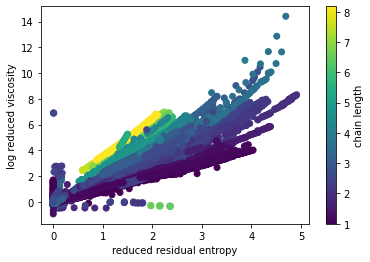

In [5]:
sc = plt.scatter( data["resd_entropy"], data["ln_eta_star_new"], c=data["m"] )

plt.xlabel("reduced residual entropy")
plt.ylabel("log reduced viscosity")
plt.colorbar(sc, label="chain length")

print("full initial dataset", len( substance_ids ), "species")

the data set contains viscosity data for 154 substances, some of which are very poorly measured. Poorly measured substances and outliers were therefore removed from the data set.

Since all substances are analysed individually, the data set was thinned out extensively to obtain around 20 to 30 well-measured substances as the basis for the study.

cleaned dataset with  27 species


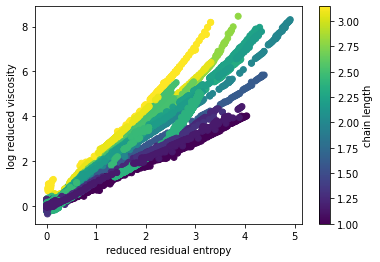

In [6]:
"""
choose species for or investigation based on several criteria:
- coverage of at least 0.5 in reduced residual entropy 
- no large gaps within the covered area ( species with gaps above 1 s* are dropped )
- outliers are dropped based on a polynomial fit
"""

y_column = "ln_eta_star_new"
good_boys = []
for sid in np.unique( data["substance_id"] ):
    sub_data = data[ data["substance_id"]==sid ]
    
    X = np.atleast_2d( sub_data[ "resd_entropy" ] ).T
    y = sub_data[ y_column ]     
    
    poly_features = PolynomialFeatures(degree=3, include_bias=False)

    Xp = poly_features.fit_transform(X)    

    lm = LinearRegression()
    lm.fit(Xp, y)

    y_pred = lm.predict(Xp)    
    
    p = np.where( np.abs( y_pred-y ) > 0.3  )

    s_star = np.sort( np.array( sub_data[y_column] ) )
    max_diff = np.max( np.diff( s_star ) )
    s_range  = np.abs( np.max(s_star) - np.min(s_star)  )
    #if max_diff < 0.7 and s_range > 2:
    if max_diff < 1.0 and s_range > 0.5:
        good_boys.append( sid )  
        drops = np.array(sub_data.index)[p]
    else:
        drops = sub_data.index
    data = data.drop( drops )
    
sc = plt.scatter( data["resd_entropy"], data[y_column], c=data["m"] )    
plt.xlabel("reduced residual entropy")
plt.ylabel("log reduced viscosity")
plt.colorbar(sc, label="chain length")

data.to_csv('vis_dataset_clean.csv',sep="\t")
print("cleaned dataset with ", len(good_boys), "species")

Compared to the initial picture we now got a dataset containing only well measured species and eliminated most clear outliers.

# 2. Objectives

The goal of this work is to investigate the univariante relationship between reduced residual entropy and log reduced viscosity for a large number of different species.
Initially the relationship was described via linear regression. In the following higher order polynomials were introduced. They are reported to perform better within areas covered by data but lack extrapolation capabilities due to overfitting. 

This issue might be adressed with LASSO and RIDGE regression.

In this work we will fit linear regression and higher order polynomials to data of different species. To analyze extrapolation capabilities, training and test data will not be selected randomly but the entropy space will be cutted into two pieces. Then one of the two sets will be splittet randomly to get training data and to be able to investigate interpolation capabilities. After analyzing the state of the art we will use LASSO and RIDGE regression for the same task and investigate if those methods lead to improved results for extrapolation and interpolation. LASSO and RIDGE will include hyperparameter tuning.

This leads to the following steps:

- split dataset to train and test data
- write wrapper 
- optimize hyperparameters for ridge and lasso
- compare linear regression, ridge and lasso

After those steps we shoul be able to conclude if ridge and/or lasso are useful within this application.


# 3. Preliminary Work

## split dataset

The dataset for each species is split into training and validation data.
Validation data is selected in such a way that both interpolation and extrapolation capability can be tested.
To test extrapolation capabilites, certain areas are excluded fom being able to occur in the training data.

These areas are relatively small, as polynomials (whether trained with RIDGE or LASSO or not) are generally not expected to have great extrapolation capabilities. It is more about avoiding completely absurd behaviour than actually predicting things (at least that is our working hypothesis, we like to be surprised).

In [7]:
def split_train_test_set(data,substance_id, y_column="ln_eta_star",
                         # test_size=0.6,extra_size=0.1, minborder=2.5): # use this if nothings better :P
                         test_size=0.5,extra_size=0.15, minborder=2.5):
    
    sub_data = data[ data["substance_id"]==substance_id ]
    print("sub_data shape:", sub_data.shape )
    
    smin = np.min(sub_data["resd_entropy"] )
    smax = np.max(sub_data["resd_entropy"] )
    sdiff = smax - smin
    print("sminmaxdiff",smin,smax,sdiff)
    
    sborder = np.max( [ minborder, smax*(1-extra_size) ] )
    print("sborder",sborder)
    
    ex_data = sub_data[ sub_data["resd_entropy"] > sborder ]
    in_data = sub_data[ sub_data["resd_entropy"] <= sborder ]
    
    train, in_test = train_test_split(in_data, test_size=test_size, random_state=42)
    test = pd.concat( [ex_data, in_test] )
    print("train test shape:", train.shape, test.shape )
    X_plot = np.atleast_2d( np.linspace(smin,smax,100) ).T
    
    X_train = np.atleast_2d( train[ "resd_entropy" ] ).T
    y_train = train[ y_column ] 

    X_test = np.atleast_2d( test[ "resd_entropy" ] ).T
    y_test = test[ y_column ] 

    return X_train, X_test, X_plot, y_train, y_test
    
X_train, X_test, X_plot, y_train, y_test = split_train_test_set( data, good_boys[0], y_column="ln_eta_star_new" )    

sub_data shape: (859, 46)
sminmaxdiff 3.2018796350741024e-05 2.5682818824128137 2.568249863616463
sborder 2.5
train test shape: (419, 46) (440, 46)


# wrapper

In this example, there is only one feature (s*) that is trained sequentially and individually for different substances. Therefore, we need a suitable wrapper that manages the whole thing and works with all linear regression, ridge and lasso.

In [8]:
class hyperparameter_wrapper():
    
    def __init__(self, model, degree=4 ):
        self.model = model
        self.degree = degree
        return
        
    def fit(self, alpha0, X_hyptrains, X_hyptests, y_hyptrains, y_hyptests, substance_ids):
        self.X_hyptrains = X_hyptrains
        self.X_hyptests  = X_hyptests
        self.y_hyptrains = y_hyptrains
        self.y_hyptests  = y_hyptests
        self.substance_ids = substance_ids
        
        res = minimize( self.error_loop, alpha0 )
        self.res = res
        self.p = res.x        
        
        return
        
    def error_loop(self,alpha,plot=False):
        error = 0
        for i, substance_id in enumerate(substance_ids):
            X_train = self.X_hyptrains[i]
            X_test  = self.X_hyptests[i]
            y_train = self.y_hyptrains[i]
            y_test = self.y_hyptests[i]
            
            model_features = PolynomialFeatures(degree=self.degree, include_bias=False)

            X_train_model = model_features.fit_transform(X_train)
            X_test_model  = model_features.transform(X_test)
            
            if alpha:
                m = self.model(alpha)
            else:
                m = self.model()
            
            m.fit( X_train_model, y_train)

            y_train_pred = m.predict(X_train_model)
            y_test_pred  = m.predict(X_test_model)
            
            error1 = mean_squared_error(y_train, y_train_pred)
            error2 = mean_squared_error(y_test, y_test_pred)
            #print(i,substance_id)
            error += error1 + error2
        print( "one loop done", error, alpha )
        return error
            
    def plot_loop(self, alpha, X_hyptrains, X_hyptests, y_hyptrains, y_hyptests, substance_ids,
                  plot=True, return_what="mean"):
        error_train = []
        error_test = []
        for i, substance_id in enumerate(substance_ids):
            X_train = X_hyptrains[i]
            X_test  = X_hyptests[i]
            y_train = y_hyptrains[i]
            y_test = y_hyptests[i]                

            model_features = PolynomialFeatures(degree=self.degree, include_bias=False)

            X_train_model = model_features.fit_transform(X_train)
            X_test_model  = model_features.transform(X_test)
            
            if alpha:
                m = self.model(alpha)
            else:
                m = self.model()
            
            m.fit( X_train_model, y_train)

            y_train_pred = m.predict(X_train_model)
            y_test_pred  = m.predict(X_test_model)
            
            error1 = mean_squared_error(y_train, y_train_pred)
            error2 = mean_squared_error(y_test, y_test_pred)
            #print(i,substance_id)
            #if error1+error2 < 1:
            error_train.append( error1 ) #+= error2
            error_test.append( error2 )
            #else:
            #    print("not added")
            if plot:
                plt.title( "train: "+str(round(error1,6))+ "MSE  test: "+str(round(error2,6))+"MSE" )
                plt.scatter( X_test, y_test, label="test "+str(round(error2*100,2))+"%" )
                plt.scatter( X_train, y_train, label="train "+str(round(error1*100,2))+"%", marker="."  )
                plt.plot( X_test, y_test_pred, ".k", label="prediction" )
                plt.plot( X_train, y_train_pred, ".k",  )
                plt.legend()
                plt.show()
                plt.close()            
        if return_what=="median":
            return np.median(error_train), np.median(error_test)
        elif return_what=="mean":
            return np.median(error_train), np.median(error_test)
        elif return_what=="list":
            return error_train, error_test



# hyperparameters

We only use a subset of species for the hyperparameter tuning:

In [9]:
hyper_train_species, hyper_test_species = train_test_split(good_boys,test_size=0.5,random_state=13)

X_hyptrains = []
X_hyptests  = []
y_hyptrains = []
y_hyptests  = []
substance_ids = []

for sid in hyper_train_species:
    try:
        X_train, X_test, X_plot, y_train, y_test = split_train_test_set( data, sid, y_column='ln_eta_star_new' )    
        X_hyptrains.append( X_train )
        y_hyptrains.append( y_train )
        X_hyptests.append( X_test )
        y_hyptests.append( y_test )
        substance_ids.append(sid)
    except:
        None



sub_data shape: (3131, 46)
sminmaxdiff 0.0001024735690789 3.1056399189089223 3.105537445339843
sborder 2.639793931072584
train test shape: (696, 46) (2435, 46)
sub_data shape: (374, 46)
sminmaxdiff 0.0028397863733588 1.6808892596745753 1.6780494733012163
sborder 2.5
train test shape: (187, 46) (187, 46)
sub_data shape: (596, 46)
sminmaxdiff 0.0001690559277615 3.9391367969723583 3.9389677410445967
sborder 3.3482662774265046
train test shape: (271, 46) (325, 46)
sub_data shape: (93, 46)
sminmaxdiff 0.0004329970152985 3.550557262481215 3.5501242654659166
sborder 3.0179736731090325
train test shape: (38, 46) (55, 46)
sub_data shape: (886, 46)
sminmaxdiff 0.000240566447855 3.3156274292690577 3.3153868628212027
sborder 2.818283314878699
train test shape: (434, 46) (452, 46)
sub_data shape: (848, 46)
sminmaxdiff 0.0001151192909619 1.693885845289378 1.693770725998416
sborder 2.5
train test shape: (424, 46) (424, 46)
sub_data shape: (259, 46)
sminmaxdiff 0.0004156560731626 0.5127016983274798 0.

### scan hyperparameters

As the only hyperparameter for ridge and lasso is alpha, we can simply loop over alpha and the degree of the polynomial:

In [10]:
degrees = [ 3,4,5,6]
alphas  = [0.00001,0.00005, 0.0001,0.0002, 0.0003, 0.0004, 0.0005,0.001,0.007,0.01,0.02, 0.03 ,0.1,1]

lasso_errors = []
ridge_errors = []
for degree in degrees:
    for alpha in alphas:
        print( degree, alpha )
        hw = hyperparameter_wrapper(Lasso,degree=degree)
        error_train,error_test = hw.plot_loop( alpha, X_hyptrains, X_hyptests, y_hyptrains, y_hyptests, substance_ids,plot=False)
        lasso_errors.append( { "error_train":error_train, "error_test":error_test, 
                              "degree":degree,"alpha":alpha  } )

        hw = hyperparameter_wrapper(Ridge,degree=degree)
        error_train,error_test = hw.plot_loop( alpha, X_hyptrains, X_hyptests, y_hyptrains, y_hyptests, substance_ids,plot=False)
        ridge_errors.append( { "error_train":error_train, "error_test":error_test, 
                              "degree":degree,"alpha":alpha  } )     
        

3 1e-05
3 5e-05
3 0.0001
3 0.0002


/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.213e+00, tolerance: 1.288e-01
  model = cd_fast.enet_coordinate_descent(
/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.864e-01, tolerance: 2.908e-02
  model = cd_fast.enet_coordinate_descent(
/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2

3 0.0003
3 0.0004
3 0.0005


/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.113e-01, tolerance: 4.386e-02
  model = cd_fast.enet_coordinate_descent(
/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.634e-01, tolerance: 1.288e-01
  model = cd_fast.enet_coordinate_descent(
/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3

3 0.001
3 0.007
3 0.01
3 0.02
3 0.03


/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.087e-03, tolerance: 4.755e-03
  model = cd_fast.enet_coordinate_descent(
/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.174e-02, tolerance: 4.386e-02
  model = cd_fast.enet_coordinate_descent(
/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1

3 0.1
3 1
4 1e-05
4 5e-05


/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.067e+00, tolerance: 1.288e-01
  model = cd_fast.enet_coordinate_descent(
/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.047e-01, tolerance: 2.908e-02
  model = cd_fast.enet_coordinate_descent(
/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2

4 0.0001


/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.975e-01, tolerance: 8.758e-02
  model = cd_fast.enet_coordinate_descent(
/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.074e-02, tolerance: 2.776e-02
  model = cd_fast.enet_coordinate_descent(
/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4

4 0.0002
4 0.0003


/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.578e+00, tolerance: 1.288e-01
  model = cd_fast.enet_coordinate_descent(
/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.032e-02, tolerance: 2.908e-02
  model = cd_fast.enet_coordinate_descent(
/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1

4 0.0004
4 0.0005


/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.290e+00, tolerance: 1.288e-01
  model = cd_fast.enet_coordinate_descent(
/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.115e-01, tolerance: 3.030e-02
  model = cd_fast.enet_coordinate_descent(
/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2

4 0.001
4 0.007


/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.957e-02, tolerance: 5.961e-02
  model = cd_fast.enet_coordinate_descent(
/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.724e-01, tolerance: 8.758e-02
  model = cd_fast.enet_coordinate_descent(
/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2

4 0.01
4 0.02
4 0.03
4 0.1
4 1
5 1e-05
5 5e-05


/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.019e+00, tolerance: 1.288e-01
  model = cd_fast.enet_coordinate_descent(
/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.006e-01, tolerance: 2.908e-02
  model = cd_fast.enet_coordinate_descent(
/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2

5 0.0001


/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.829e-01, tolerance: 2.908e-02
  model = cd_fast.enet_coordinate_descent(
/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.640e-01, tolerance: 3.030e-02
  model = cd_fast.enet_coordinate_descent(
/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4

5 0.0002
5 0.0003


/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.327e-02, tolerance: 4.755e-03
  model = cd_fast.enet_coordinate_descent(
/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.174e-02, tolerance: 5.961e-02
  model = cd_fast.enet_coordinate_descent(
/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2

5 0.0004
5 0.0005


/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.082e-01, tolerance: 3.030e-02
  model = cd_fast.enet_coordinate_descent(
/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.625e-02, tolerance: 4.755e-03
  model = cd_fast.enet_coordinate_descent(
/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7

5 0.001
5 0.007


/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.126e+00, tolerance: 7.435e-02
  model = cd_fast.enet_coordinate_descent(
/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.698e-01, tolerance: 7.435e-02
  model = cd_fast.enet_coordinate_descent(


5 0.01
5 0.02


/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.912e-02, tolerance: 1.266e-02
  model = cd_fast.enet_coordinate_descent(
/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.999e-02, tolerance: 4.386e-02
  model = cd_fast.enet_coordinate_descent(
/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5

5 0.03
5 0.1


/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.696e-02, tolerance: 4.755e-03
  model = cd_fast.enet_coordinate_descent(
/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.894e-01, tolerance: 8.758e-02
  model = cd_fast.enet_coordinate_descent(
/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4

5 1
6 1e-05


/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.001e+00, tolerance: 1.288e-01
  model = cd_fast.enet_coordinate_descent(
/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.880e-01, tolerance: 2.908e-02
  model = cd_fast.enet_coordinate_descent(
/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2

6 5e-05
6 0.0001


/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.143e-01, tolerance: 5.961e-02
  model = cd_fast.enet_coordinate_descent(
/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.755e-01, tolerance: 6.261e-02
  model = cd_fast.enet_coordinate_descent(
/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3

6 0.0002
6 0.0003


/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.668e+00, tolerance: 1.288e-01
  model = cd_fast.enet_coordinate_descent(
/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.336e-01, tolerance: 2.908e-02
  model = cd_fast.enet_coordinate_descent(
/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3

6 0.0004
6 0.0005


/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.487e-02, tolerance: 2.776e-02
  model = cd_fast.enet_coordinate_descent(
/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.418e-02, tolerance: 1.266e-02
  model = cd_fast.enet_coordinate_descent(
/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2

6 0.001
6 0.007


/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.363e+00, tolerance: 1.288e-01
  model = cd_fast.enet_coordinate_descent(
/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.446e-01, tolerance: 3.030e-02
  model = cd_fast.enet_coordinate_descent(
/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6

6 0.01
6 0.02


/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.601e-01, tolerance: 4.755e-03
  model = cd_fast.enet_coordinate_descent(
/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.900e-02, tolerance: 1.266e-02
  model = cd_fast.enet_coordinate_descent(
/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2

6 0.03
6 0.1


/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.701e-01, tolerance: 3.030e-02
  model = cd_fast.enet_coordinate_descent(
/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.570e-01, tolerance: 1.266e-02
  model = cd_fast.enet_coordinate_descent(
/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1

6 1


Now we can visualize the results dependend on alpha and degree and choose suitable hyperparameters:

<AxesSubplot:xlabel='alpha', ylabel='error_test'>

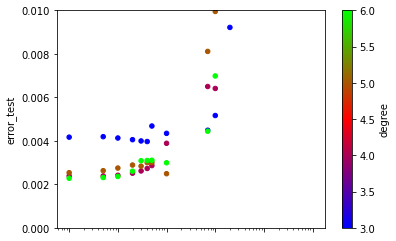

In [11]:
lasso_scan = pd.DataFrame(lasso_errors)

lasso_scan.plot(x="alpha",y="error_test",c="degree",kind="scatter",logx=True,ylim=(0,.01),colormap="brg")


/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.826e+00, tolerance: 1.288e-01
  model = cd_fast.enet_coordinate_descent(


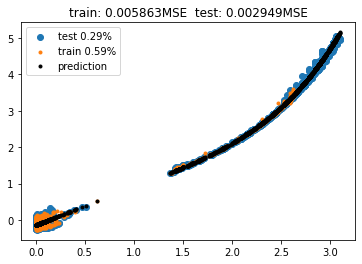

/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.626e-01, tolerance: 2.908e-02
  model = cd_fast.enet_coordinate_descent(


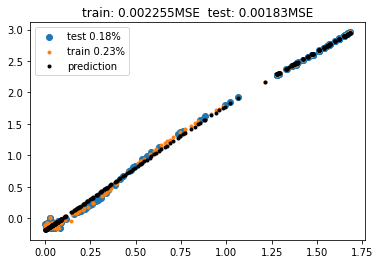

/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.694e-01, tolerance: 3.030e-02
  model = cd_fast.enet_coordinate_descent(


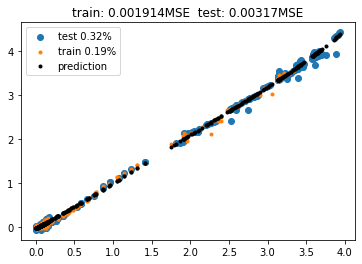

/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.233e-02, tolerance: 4.755e-03
  model = cd_fast.enet_coordinate_descent(


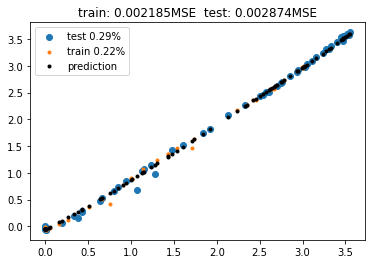

/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.503e-02, tolerance: 5.961e-02
  model = cd_fast.enet_coordinate_descent(


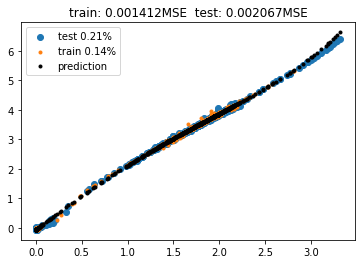

/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.208e-01, tolerance: 6.261e-02
  model = cd_fast.enet_coordinate_descent(


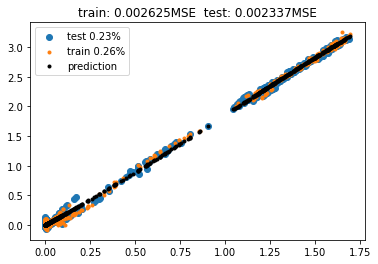

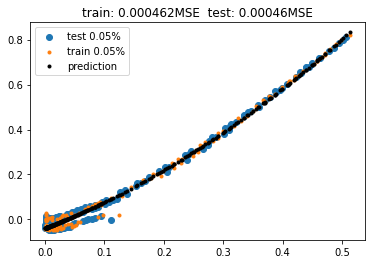

/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.336e-01, tolerance: 8.758e-02
  model = cd_fast.enet_coordinate_descent(


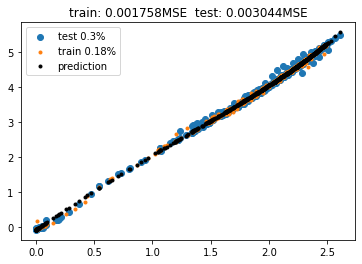

/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.401e-02, tolerance: 2.776e-02
  model = cd_fast.enet_coordinate_descent(


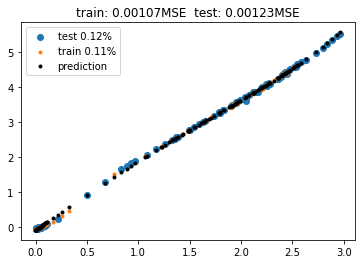

/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.056e-02, tolerance: 1.266e-02
  model = cd_fast.enet_coordinate_descent(


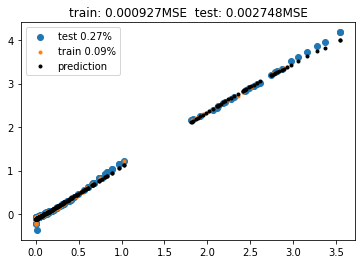

/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.272e-01, tolerance: 7.435e-02
  model = cd_fast.enet_coordinate_descent(


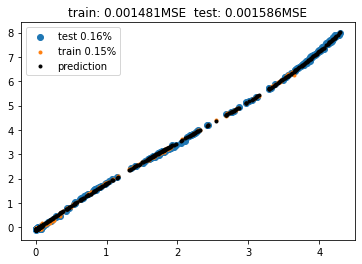

/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.830e-01, tolerance: 3.544e-02
  model = cd_fast.enet_coordinate_descent(


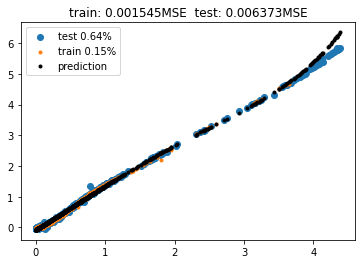

/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.890e-01, tolerance: 4.386e-02
  model = cd_fast.enet_coordinate_descent(


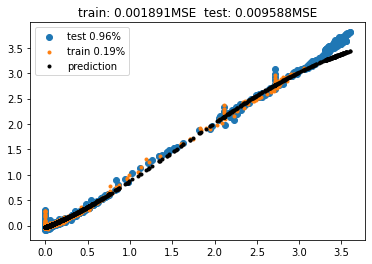

In [12]:
"""
select lasso parameters based on pareto knee
"""
lasso_degree = 5
lasso_alpha = 0.0001


hw = hyperparameter_wrapper(Lasso,degree=lasso_degree)
eee = hw.plot_loop( lasso_alpha, X_hyptrains, X_hyptests, y_hyptrains, y_hyptests, substance_ids)

<AxesSubplot:xlabel='alpha', ylabel='error_test'>

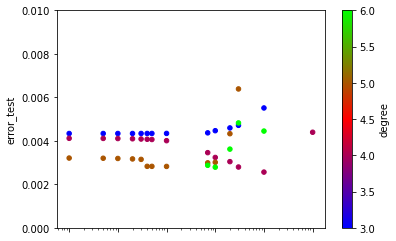

In [13]:
ridge_scan = pd.DataFrame(ridge_errors)

ridge_scan.plot(x="alpha",y="error_test",c="degree",kind="scatter",logx=True,ylim=(0,.01),colormap="brg")


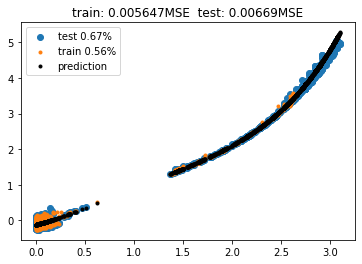

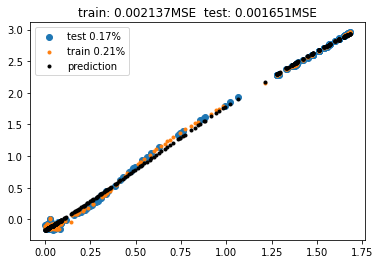

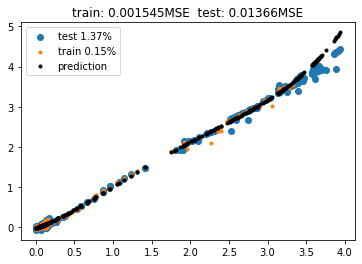

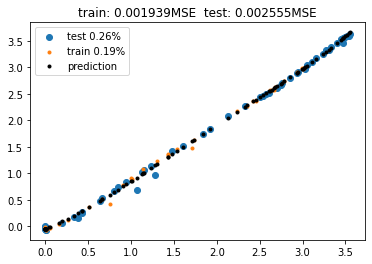

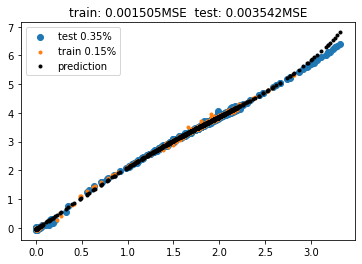

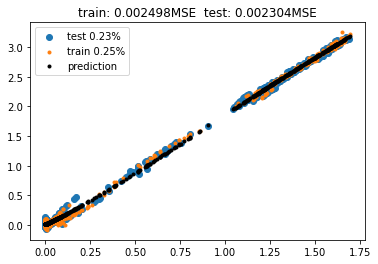

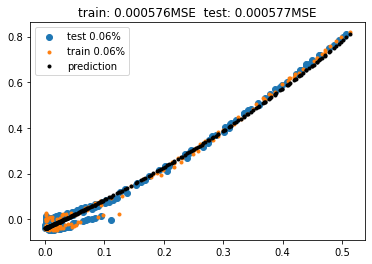

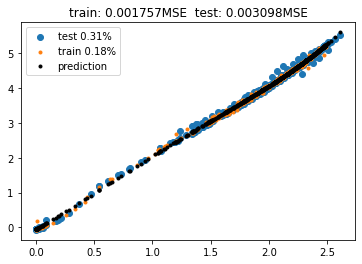

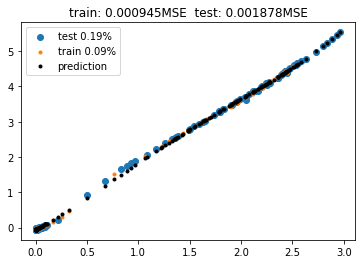

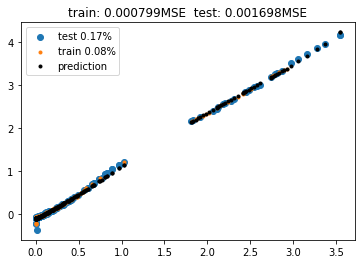

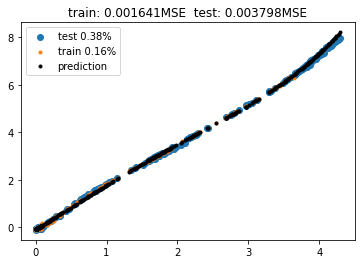

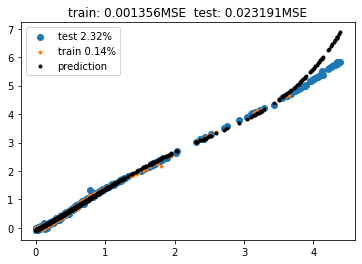

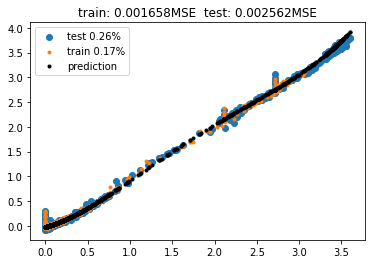

In [14]:
"""
select ridge parameters based on pareto knee
"""

ridge_degree = 4
ridge_alpha = 0.1

hw = hyperparameter_wrapper(Ridge,degree=ridge_degree)
eee = hw.plot_loop( ridge_alpha, X_hyptrains, X_hyptests, y_hyptrains, y_hyptests, substance_ids)

# 4. Linear Regression Models

Now we can apply and compare different linear regression models to the full dataset:

In [15]:
X_trains = []
X_tests  = []
y_trains = []
y_tests  = []
substance_ids = []

for sid in good_boys:
    try:
        X_train, X_test, X_plot, y_train, y_test = split_train_test_set( data, sid, y_column='ln_eta_star_new' )    
        X_trains.append( X_train )
        y_trains.append( y_train )
        X_tests.append( X_test )
        y_tests.append( y_test )
        substance_ids.append(sid)
    except:
        None



sub_data shape: (859, 46)
sminmaxdiff 3.2018796350741024e-05 2.5682818824128137 2.568249863616463
sborder 2.5
train test shape: (419, 46) (440, 46)
sub_data shape: (489, 46)
sminmaxdiff 0.0013505208108198 3.915993823944196 3.914643303133376
sborder 3.3285947503525666
train test shape: (229, 46) (260, 46)
sub_data shape: (863, 46)
sminmaxdiff 0.0002459937204622 2.611164677968871 2.6109186842484085
sborder 2.5
train test shape: (428, 46) (435, 46)
sub_data shape: (886, 46)
sminmaxdiff 0.000240566447855 3.3156274292690577 3.3153868628212027
sborder 2.818283314878699
train test shape: (434, 46) (452, 46)
sub_data shape: (1872, 46)
sminmaxdiff 0.0002969034765083 3.8626588679205263 3.862361964444018
sborder 3.2832600377324472
train test shape: (906, 46) (966, 46)
sub_data shape: (3131, 46)
sminmaxdiff 0.0001024735690789 3.1056399189089223 3.105537445339843
sborder 2.639793931072584
train test shape: (696, 46) (2435, 46)
sub_data shape: (181, 46)
sminmaxdiff 0.0015804168183064 2.9659605044479

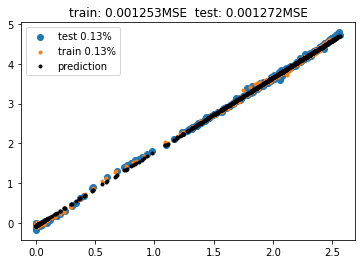

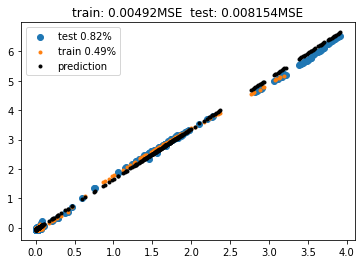

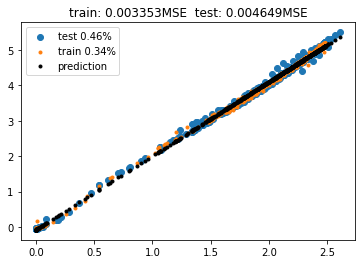

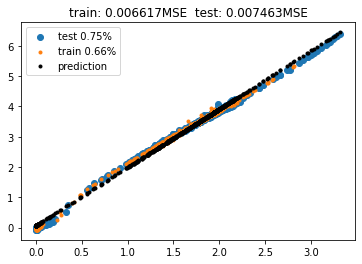

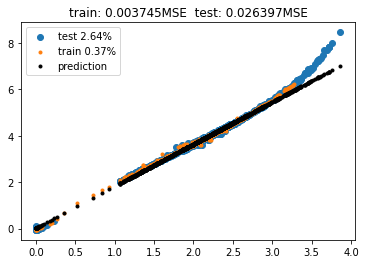

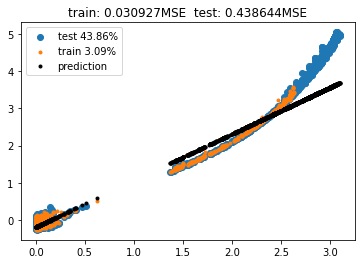

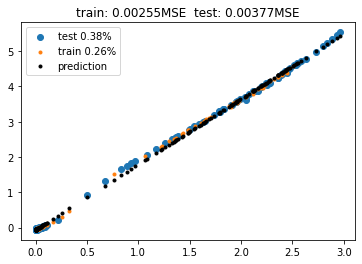

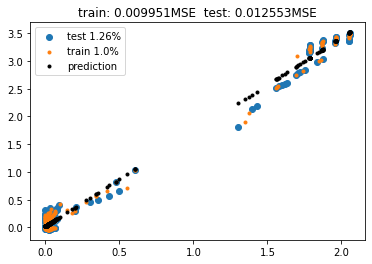

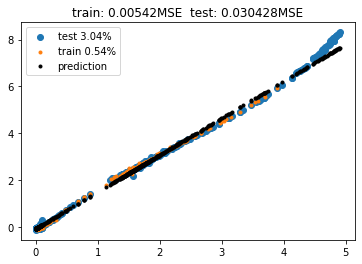

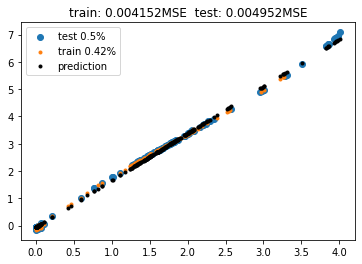

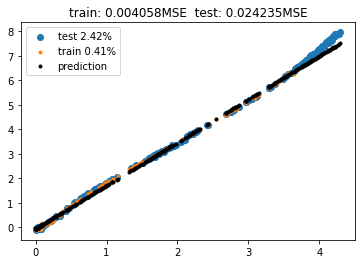

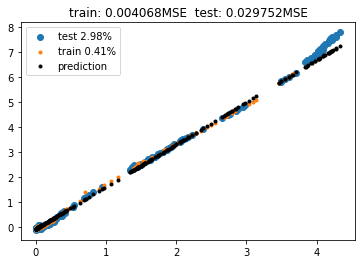

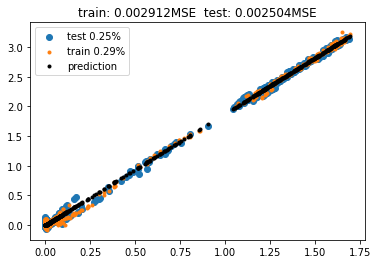

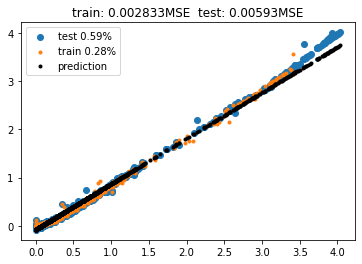

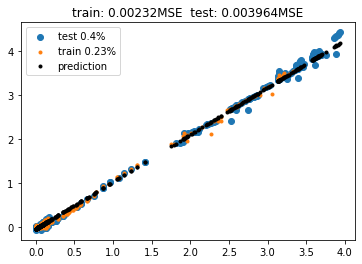

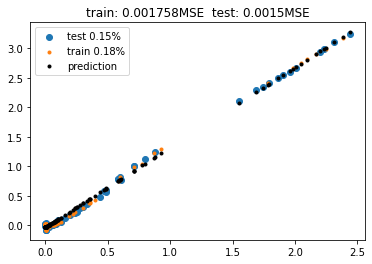

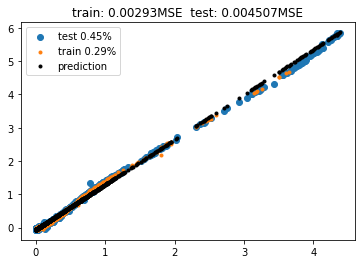

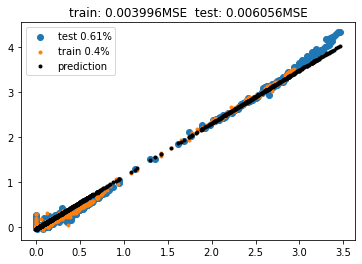

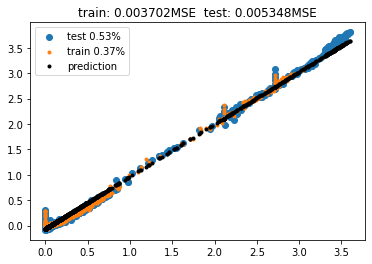

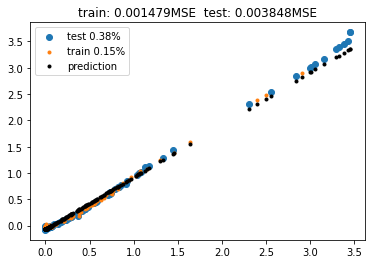

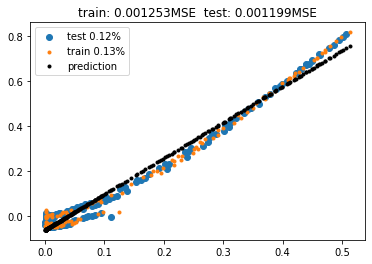

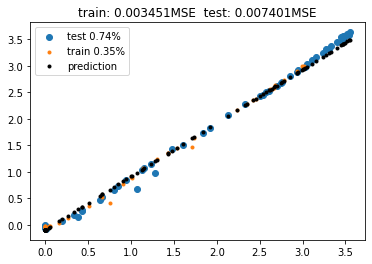

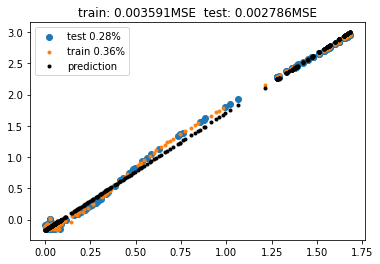

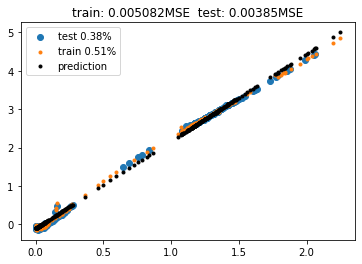

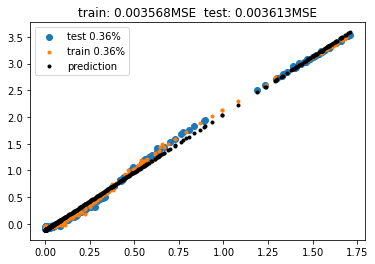

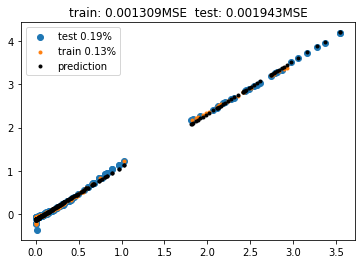

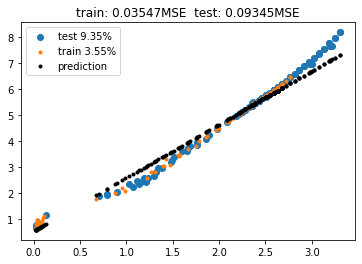

In [16]:
results = {}

hw = hyperparameter_wrapper(LinearRegression,degree=1)
li_train, li_test = hw.plot_loop( False, X_trains, X_tests, y_trains, y_tests, substance_ids)

results[ "line" ] = { "error_train":li_train, "error_test":li_test, "alpha":0, "deg":1 }

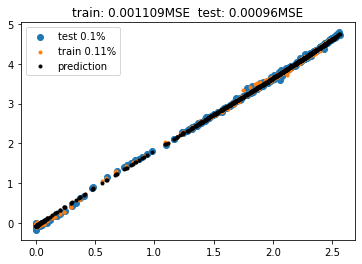

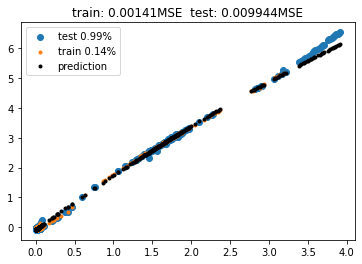

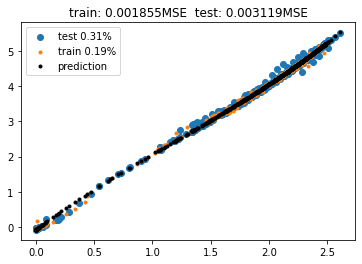

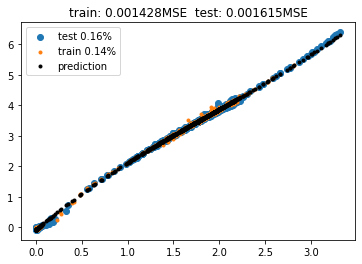

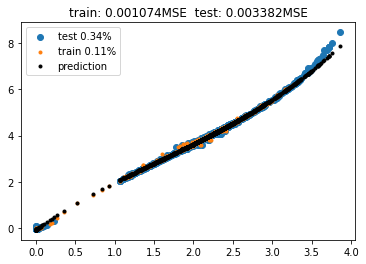

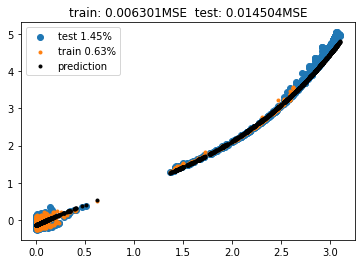

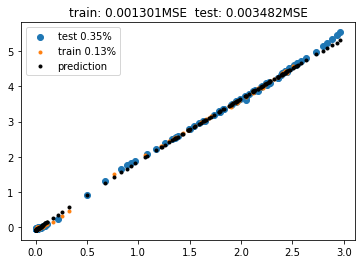

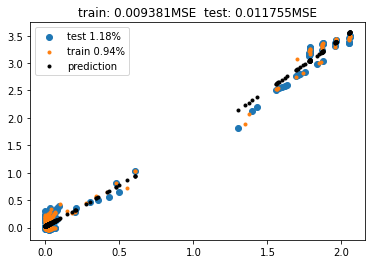

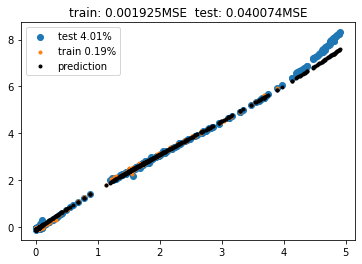

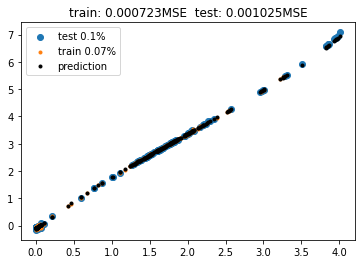

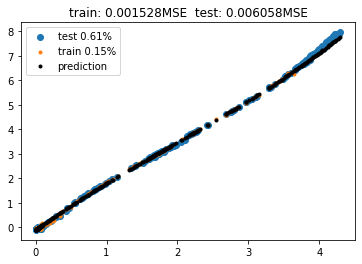

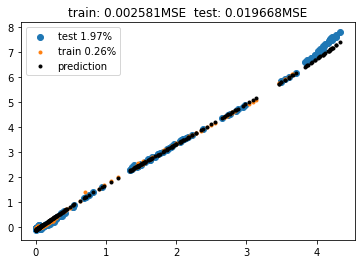

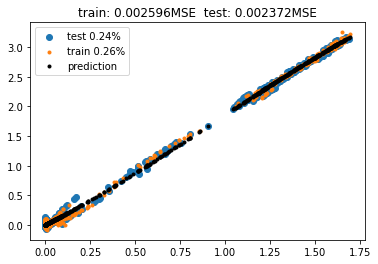

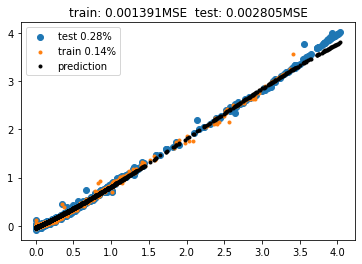

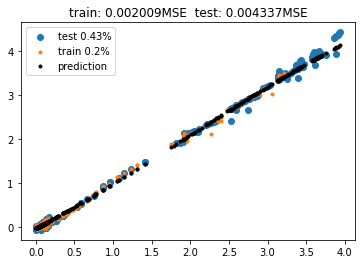

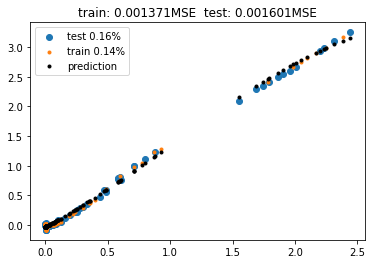

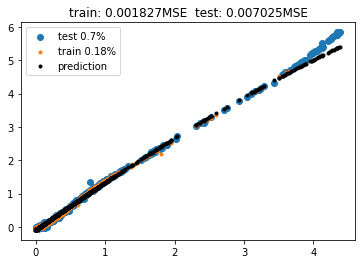

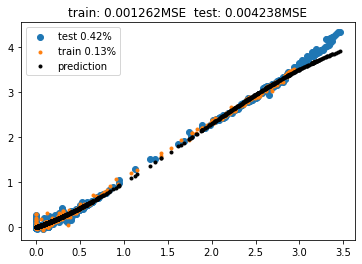

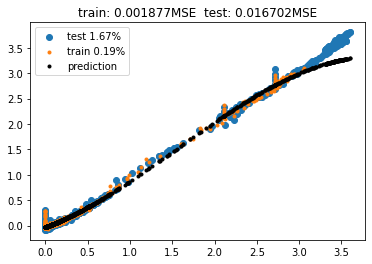

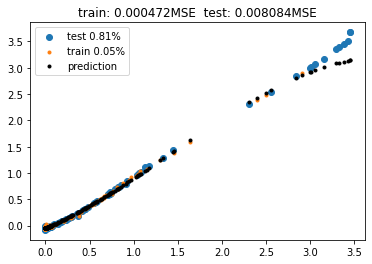

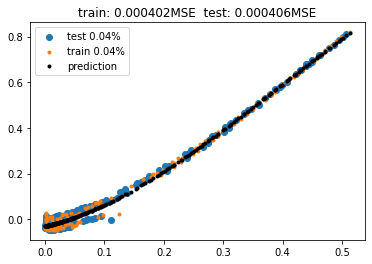

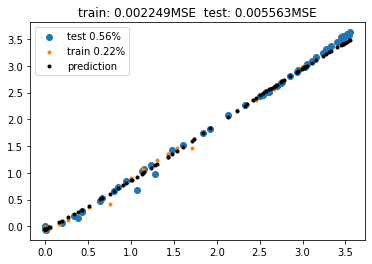

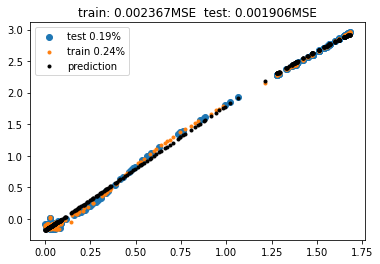

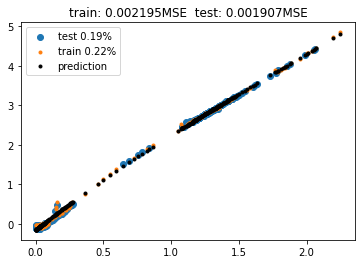

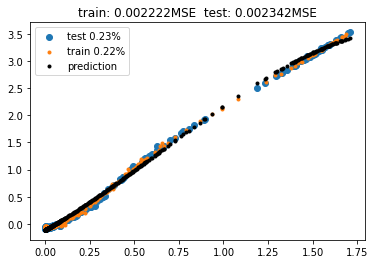

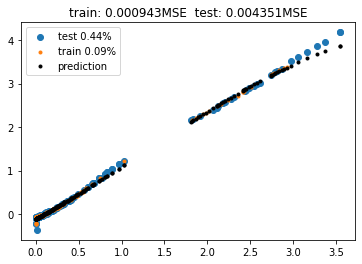

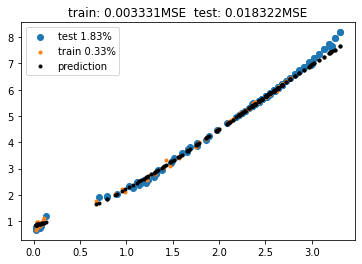

In [17]:
hw = hyperparameter_wrapper(LinearRegression,degree=3)
p3_train, p3_test = hw.plot_loop( False, X_trains, X_tests, y_trains, y_tests, substance_ids)

results[ "poly3" ] = { "error_train":p3_train, "error_test":p3_test, "alpha":0, "deg":3 }

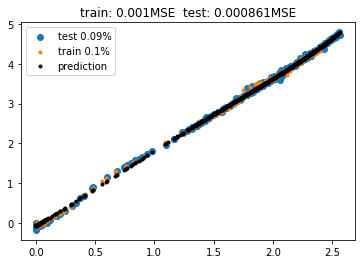

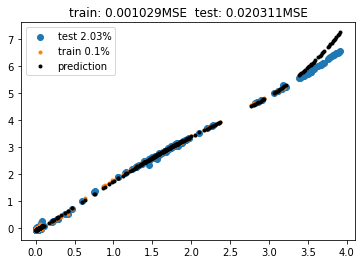

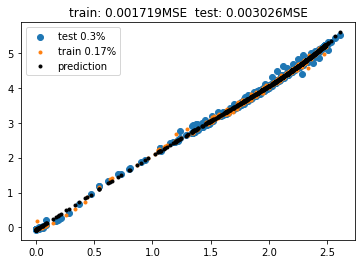

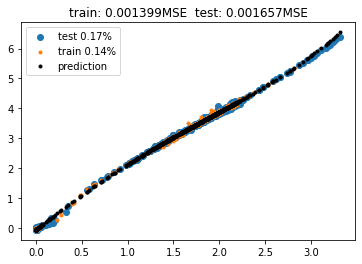

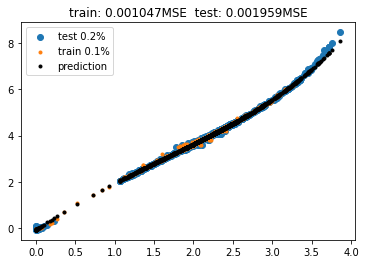

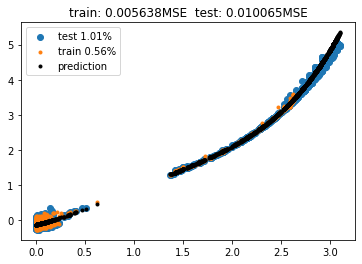

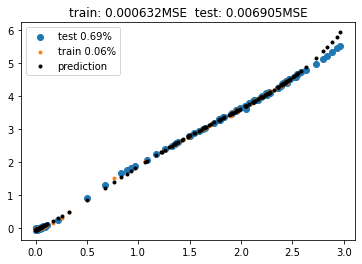

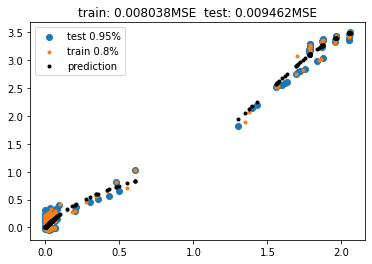

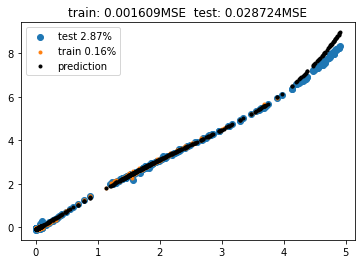

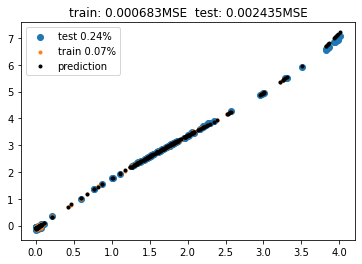

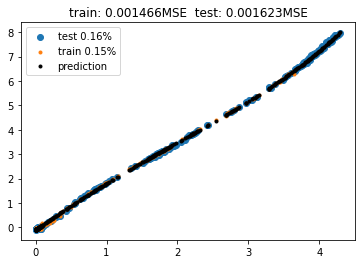

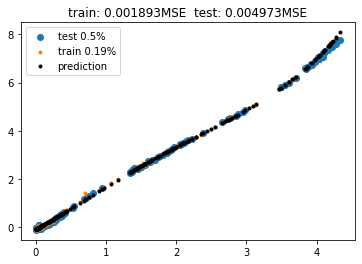

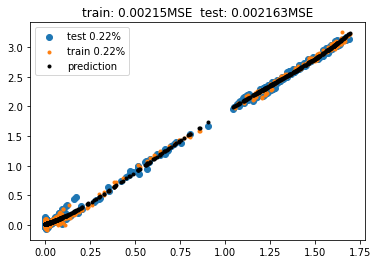

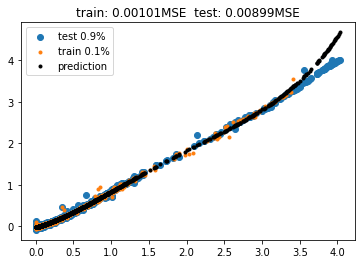

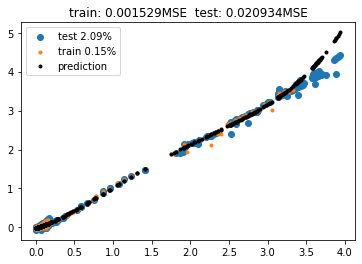

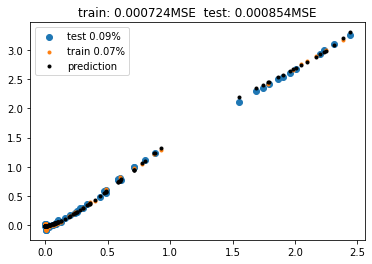

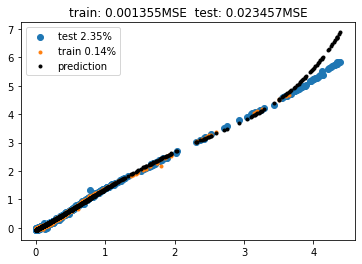

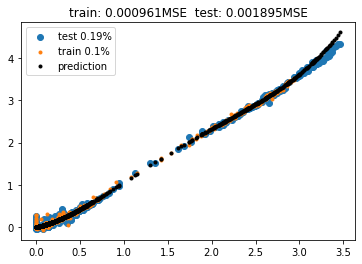

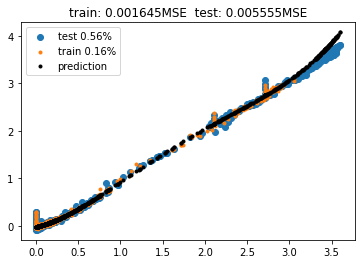

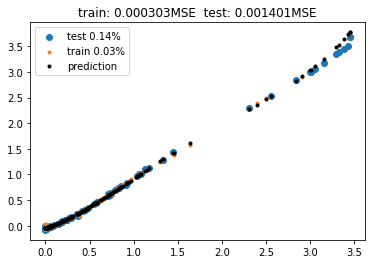

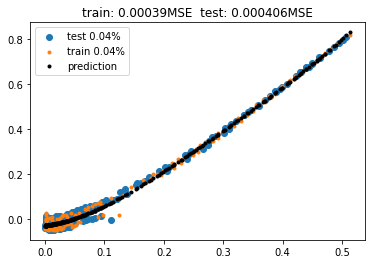

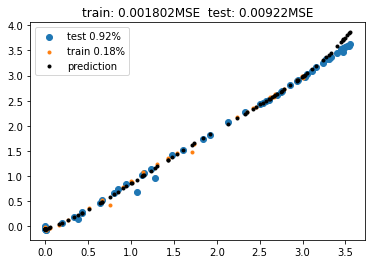

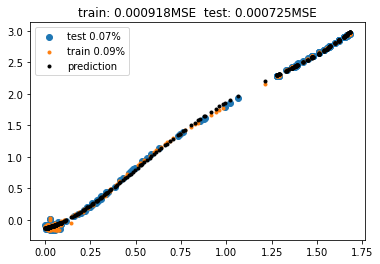

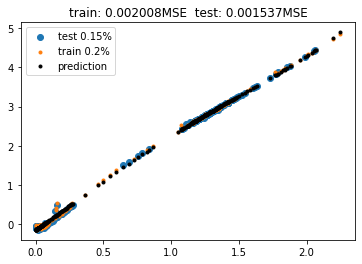

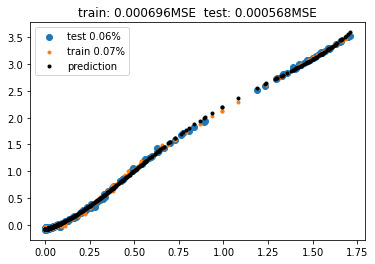

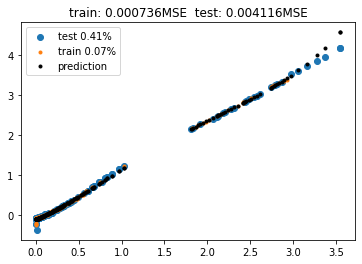

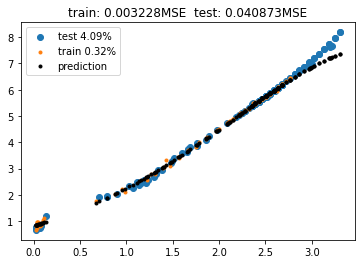

In [18]:
hw = hyperparameter_wrapper(LinearRegression,degree=4)
p4_train, p4_test = hw.plot_loop( False, X_trains, X_tests, y_trains, y_tests, substance_ids)

results[ "poly4" ] = { "error_train":p4_train, "error_test":p4_test, "alpha":0, "deg":4 }

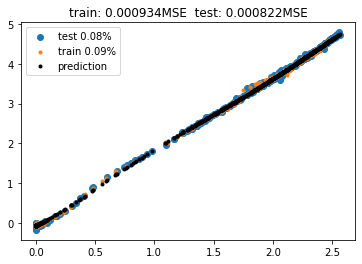

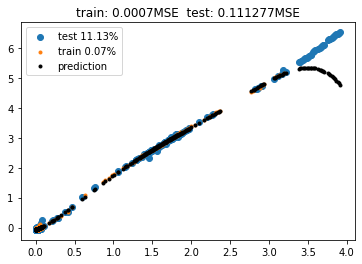

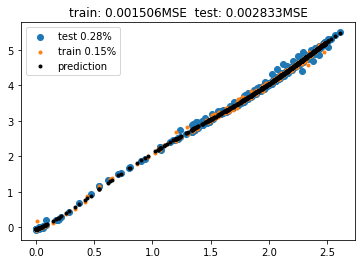

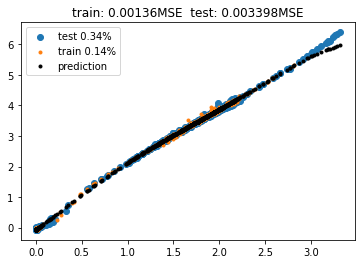

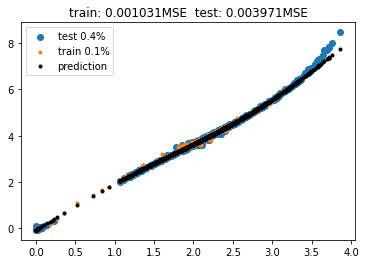

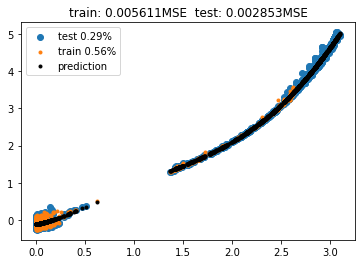

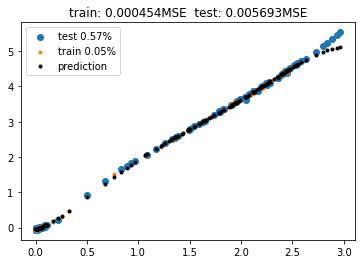

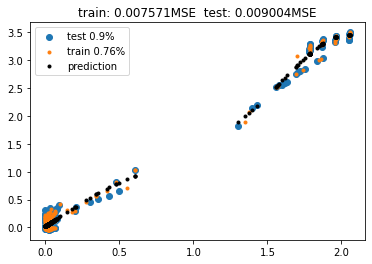

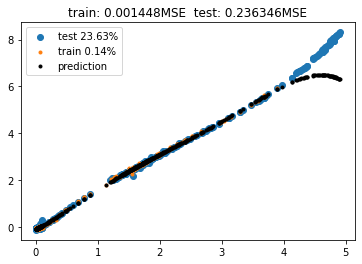

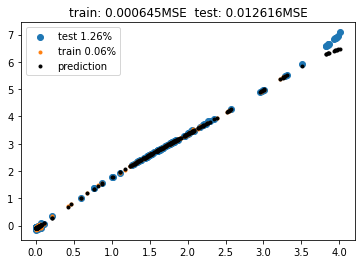

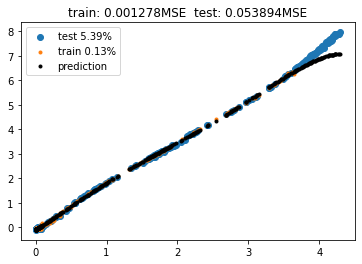

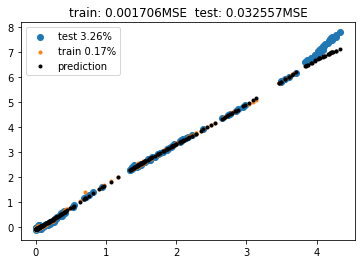

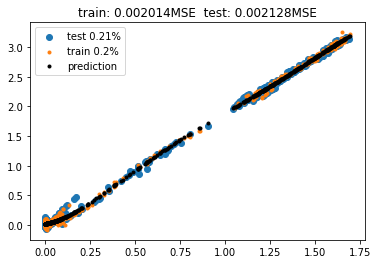

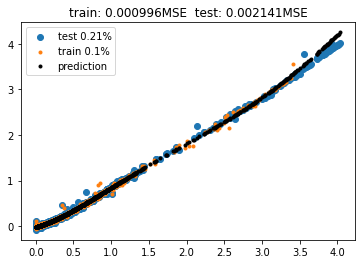

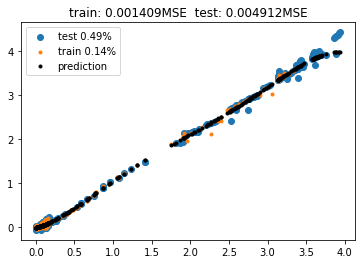

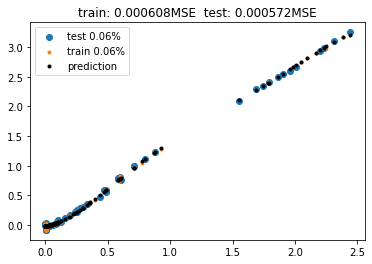

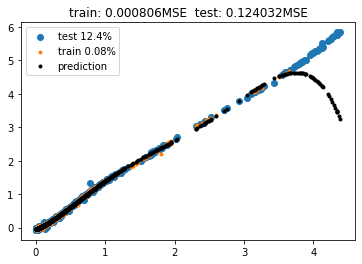

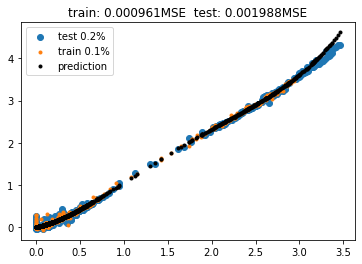

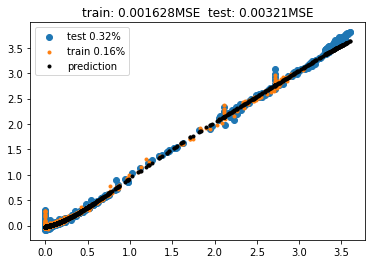

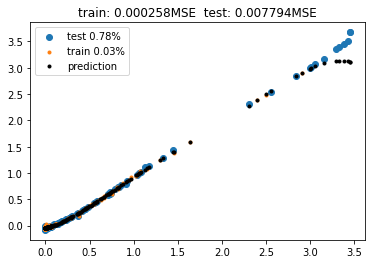

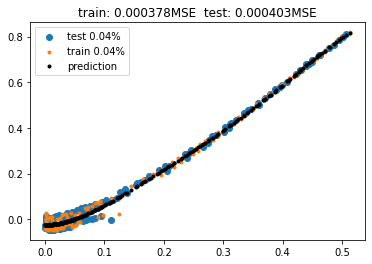

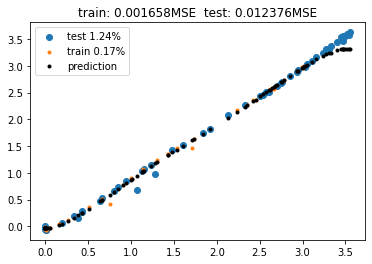

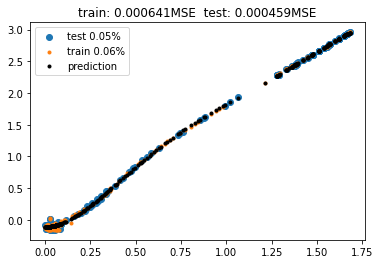

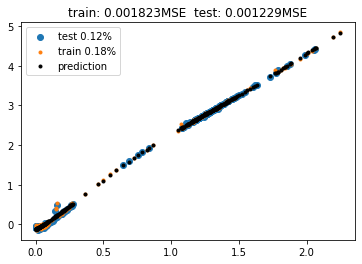

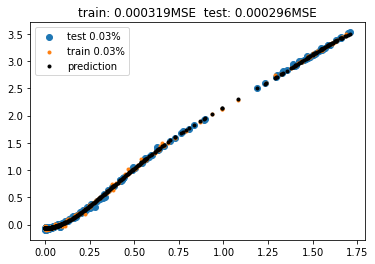

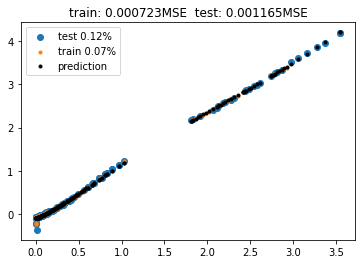

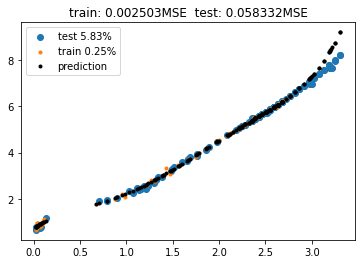

In [19]:
hw = hyperparameter_wrapper(LinearRegression,degree=5)
p5_train, p5_test = hw.plot_loop( False, X_trains, X_tests, y_trains, y_tests, substance_ids)

results[ "poly5" ] = { "error_train":p5_train, "error_test":p5_test, "alpha":0, "deg":5 }

/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.082e-01, tolerance: 1.098e-01
  model = cd_fast.enet_coordinate_descent(


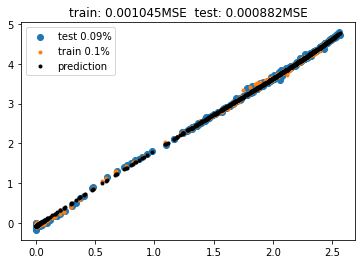

/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.600e-01, tolerance: 5.824e-02
  model = cd_fast.enet_coordinate_descent(


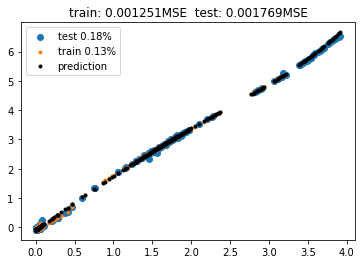

/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.336e-01, tolerance: 8.758e-02
  model = cd_fast.enet_coordinate_descent(


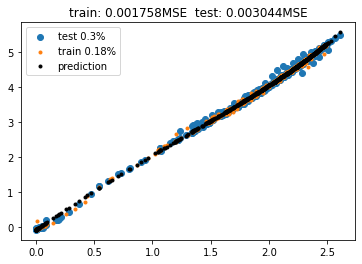

/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.503e-02, tolerance: 5.961e-02
  model = cd_fast.enet_coordinate_descent(


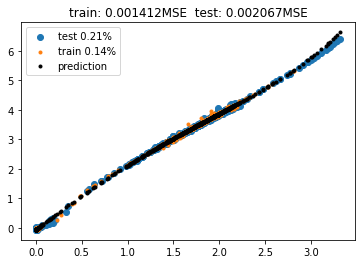

/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.927e-01, tolerance: 9.162e-02
  model = cd_fast.enet_coordinate_descent(


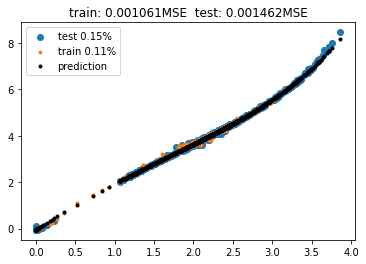

/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.826e+00, tolerance: 1.288e-01
  model = cd_fast.enet_coordinate_descent(


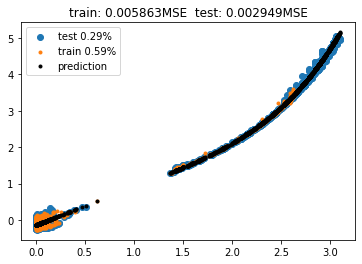

/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.401e-02, tolerance: 2.776e-02
  model = cd_fast.enet_coordinate_descent(


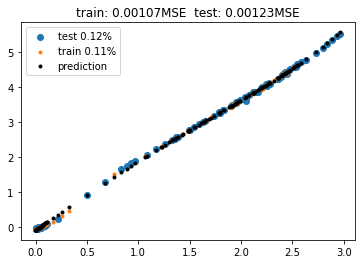

/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.460e-01, tolerance: 3.043e-02
  model = cd_fast.enet_coordinate_descent(


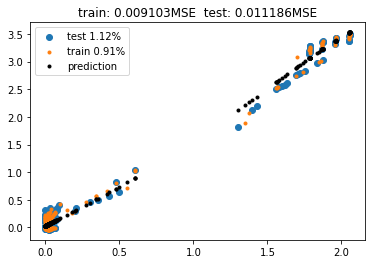

/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.528e-01, tolerance: 7.508e-02
  model = cd_fast.enet_coordinate_descent(


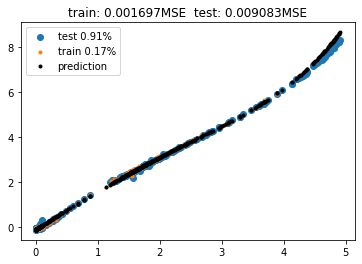

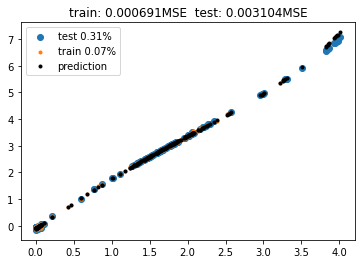

/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.272e-01, tolerance: 7.435e-02
  model = cd_fast.enet_coordinate_descent(


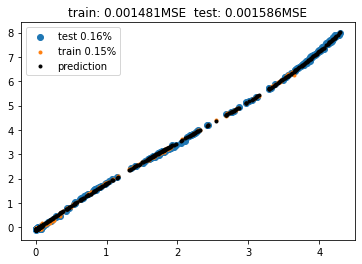

/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.497e-01, tolerance: 4.422e-02
  model = cd_fast.enet_coordinate_descent(


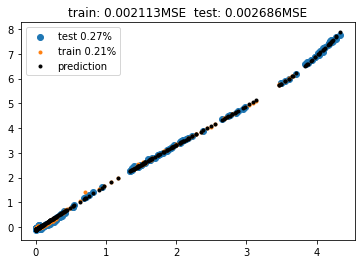

/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.208e-01, tolerance: 6.261e-02
  model = cd_fast.enet_coordinate_descent(


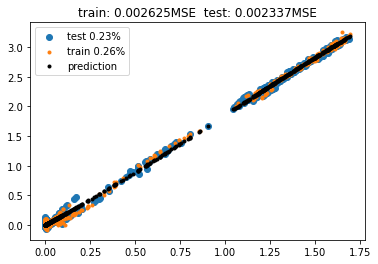

/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.661e-01, tolerance: 3.524e-02
  model = cd_fast.enet_coordinate_descent(


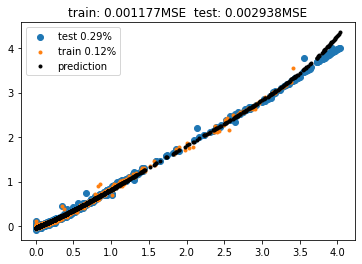

/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.694e-01, tolerance: 3.030e-02
  model = cd_fast.enet_coordinate_descent(


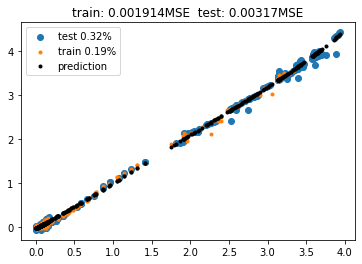

/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.820e-02, tolerance: 5.504e-03
  model = cd_fast.enet_coordinate_descent(


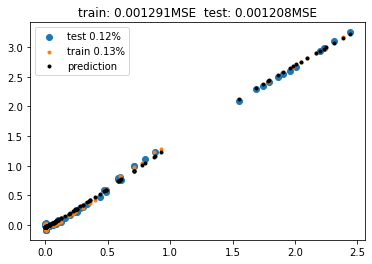

/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.830e-01, tolerance: 3.544e-02
  model = cd_fast.enet_coordinate_descent(


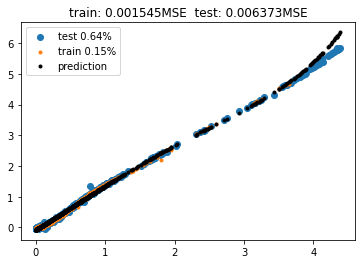

/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.860e-01, tolerance: 7.859e-02
  model = cd_fast.enet_coordinate_descent(


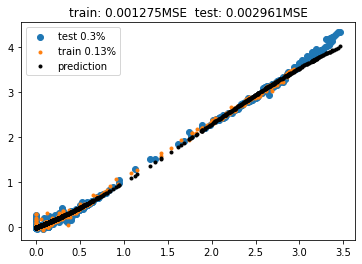

/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.890e-01, tolerance: 4.386e-02
  model = cd_fast.enet_coordinate_descent(


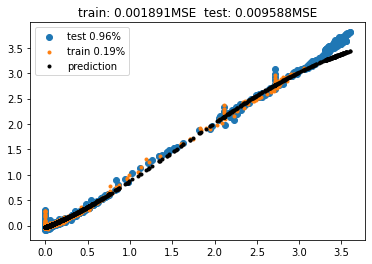

/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.861e-02, tolerance: 3.192e-03
  model = cd_fast.enet_coordinate_descent(


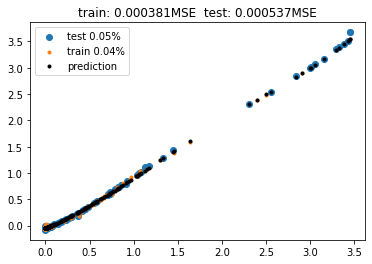

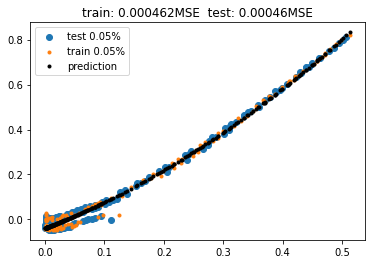

/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.233e-02, tolerance: 4.755e-03
  model = cd_fast.enet_coordinate_descent(


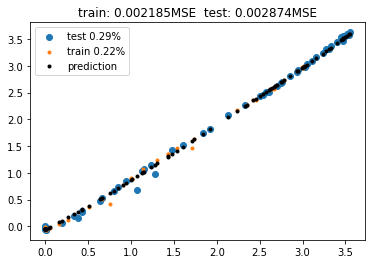

/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.626e-01, tolerance: 2.908e-02
  model = cd_fast.enet_coordinate_descent(


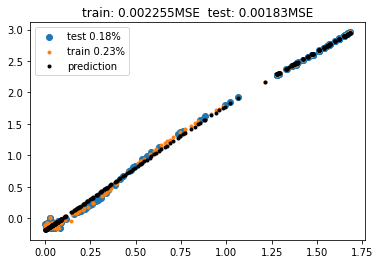

/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.349e-02, tolerance: 3.785e-02
  model = cd_fast.enet_coordinate_descent(


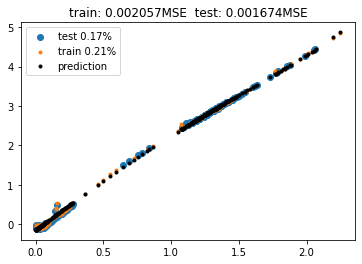

/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.905e-01, tolerance: 2.987e-02
  model = cd_fast.enet_coordinate_descent(


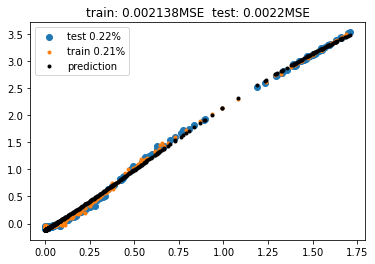

/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.056e-02, tolerance: 1.266e-02
  model = cd_fast.enet_coordinate_descent(


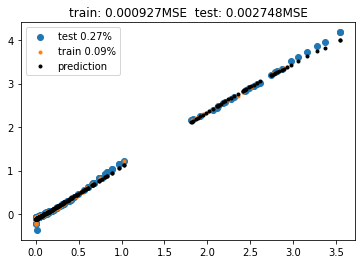

/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.073e-02, tolerance: 3.071e-02
  model = cd_fast.enet_coordinate_descent(


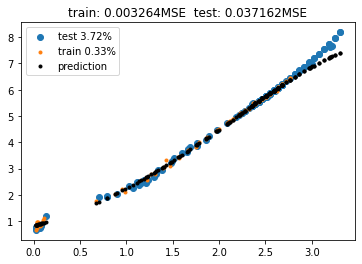

In [20]:
hw = hyperparameter_wrapper(Lasso,degree=lasso_degree)
la_train, la_test = hw.plot_loop( lasso_alpha, X_trains, X_tests, y_trains, y_tests, substance_ids)

results[ "lasso" ] = { "error_train":la_train, "error_test":la_test, "alpha":lasso_alpha, "deg":lasso_degree }

/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.880e-01, tolerance: 1.098e-01
  model = cd_fast.enet_coordinate_descent(


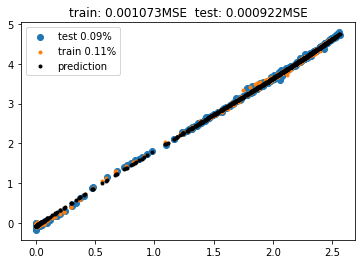

/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.502e-01, tolerance: 5.824e-02
  model = cd_fast.enet_coordinate_descent(


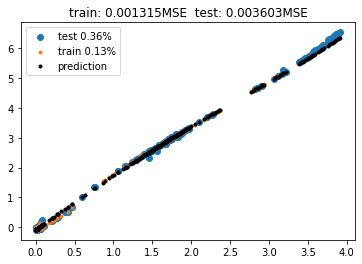

/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.797e-01, tolerance: 8.758e-02
  model = cd_fast.enet_coordinate_descent(


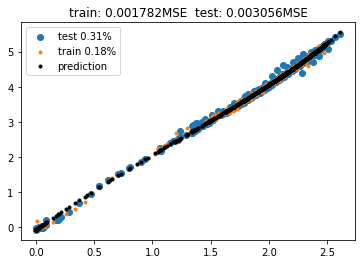

/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.420e-01, tolerance: 5.961e-02
  model = cd_fast.enet_coordinate_descent(


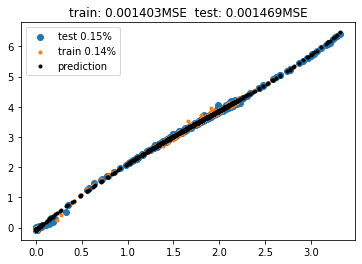

/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.910e-01, tolerance: 9.162e-02
  model = cd_fast.enet_coordinate_descent(


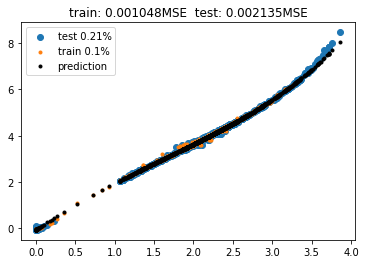

/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.796e+00, tolerance: 1.288e-01
  model = cd_fast.enet_coordinate_descent(


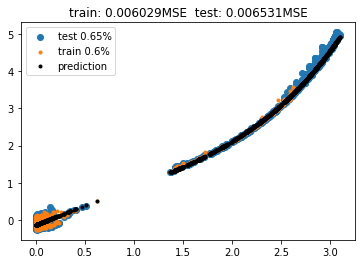

/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.181e-02, tolerance: 2.776e-02
  model = cd_fast.enet_coordinate_descent(


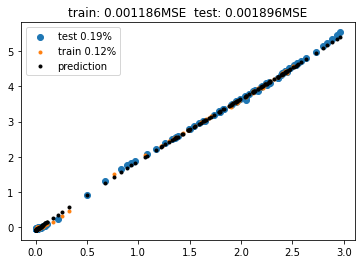

/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.144e-01, tolerance: 3.043e-02
  model = cd_fast.enet_coordinate_descent(


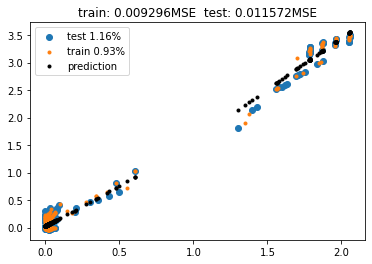

/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.473e-01, tolerance: 7.508e-02
  model = cd_fast.enet_coordinate_descent(


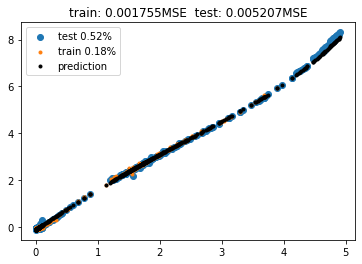

/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.472e-02, tolerance: 3.738e-02
  model = cd_fast.enet_coordinate_descent(


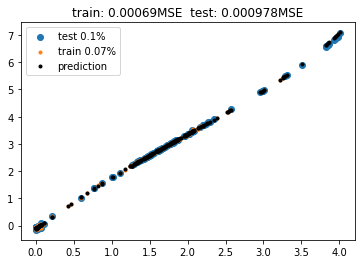

/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.966e-02, tolerance: 7.435e-02
  model = cd_fast.enet_coordinate_descent(


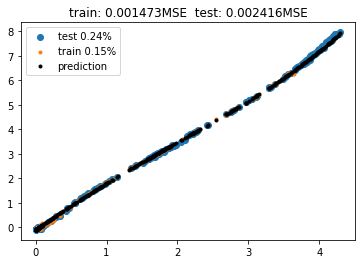

/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.504e-01, tolerance: 4.422e-02
  model = cd_fast.enet_coordinate_descent(


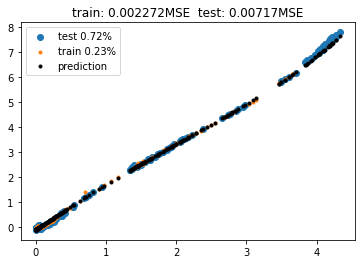

/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.109e-02, tolerance: 6.261e-02
  model = cd_fast.enet_coordinate_descent(


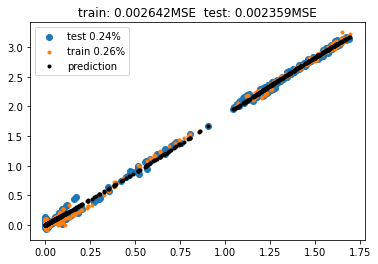

/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.330e-01, tolerance: 3.524e-02
  model = cd_fast.enet_coordinate_descent(


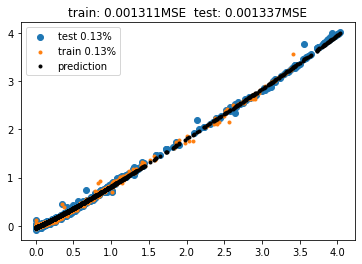

/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.325e-01, tolerance: 3.030e-02
  model = cd_fast.enet_coordinate_descent(


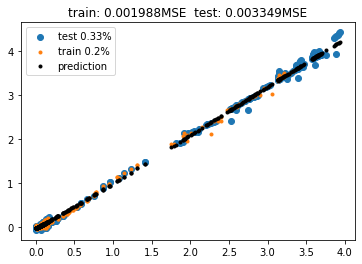

/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.835e-02, tolerance: 5.504e-03
  model = cd_fast.enet_coordinate_descent(


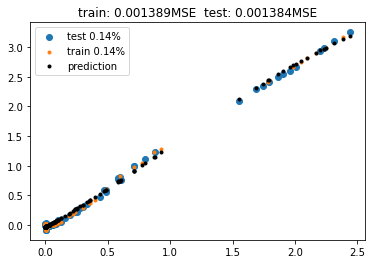

/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.908e-01, tolerance: 3.544e-02
  model = cd_fast.enet_coordinate_descent(


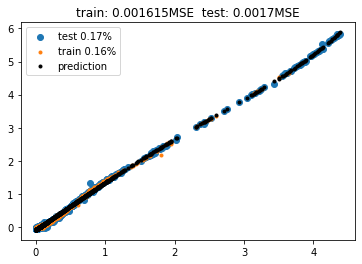

/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.174e-01, tolerance: 7.859e-02
  model = cd_fast.enet_coordinate_descent(


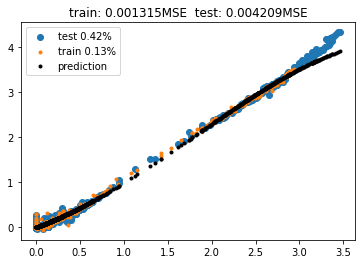

/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.915e-01, tolerance: 4.386e-02
  model = cd_fast.enet_coordinate_descent(


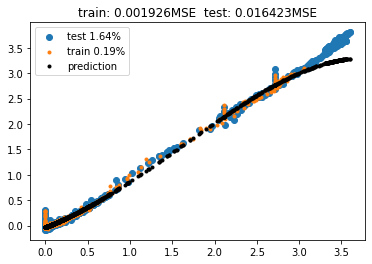

/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.174e-02, tolerance: 3.192e-03
  model = cd_fast.enet_coordinate_descent(


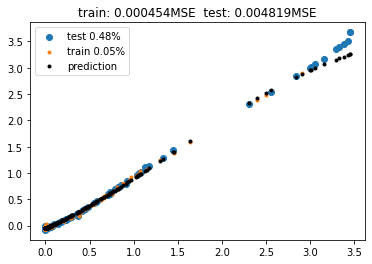

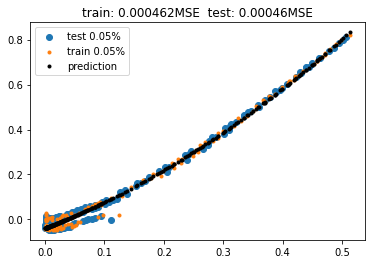

/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.647e-02, tolerance: 4.755e-03
  model = cd_fast.enet_coordinate_descent(


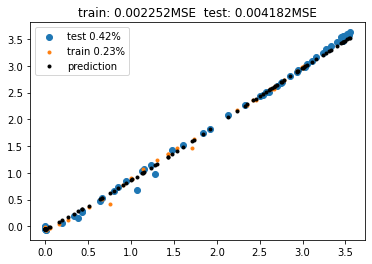

/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.123e-02, tolerance: 2.908e-02
  model = cd_fast.enet_coordinate_descent(


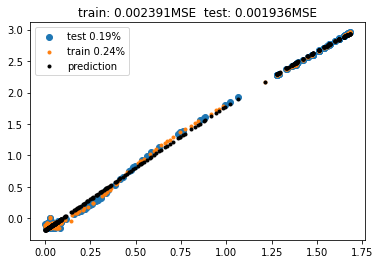

/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.014e-01, tolerance: 3.785e-02
  model = cd_fast.enet_coordinate_descent(


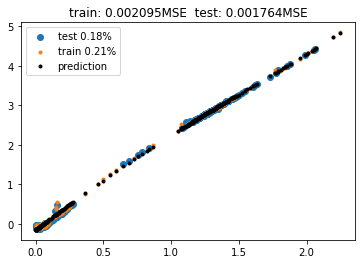

/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.353e-01, tolerance: 2.987e-02
  model = cd_fast.enet_coordinate_descent(


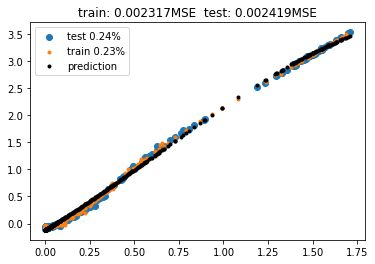

/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.195e-02, tolerance: 1.266e-02
  model = cd_fast.enet_coordinate_descent(


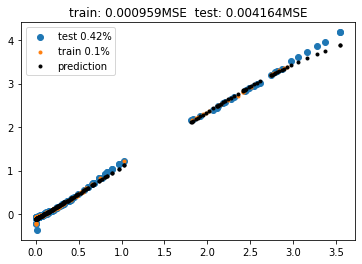

/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.330e-02, tolerance: 3.071e-02
  model = cd_fast.enet_coordinate_descent(


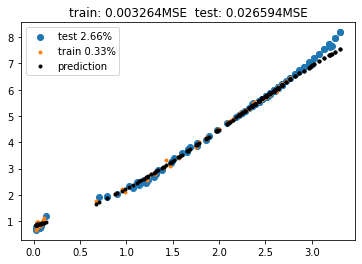

In [21]:
hw = hyperparameter_wrapper(Lasso,degree=4)
la_train, la_test = hw.plot_loop( lasso_alpha, X_trains, X_tests, y_trains, y_tests, substance_ids)

results[ "lasso4" ] = { "error_train":la_train, "error_test":la_test, "alpha":lasso_alpha, "deg":4 }

/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.277e-01, tolerance: 1.098e-01
  model = cd_fast.enet_coordinate_descent(


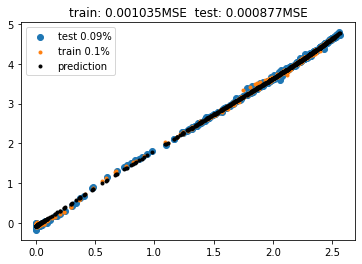

/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.530e-01, tolerance: 5.824e-02
  model = cd_fast.enet_coordinate_descent(


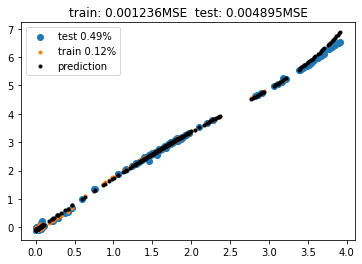

/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.438e-01, tolerance: 8.758e-02
  model = cd_fast.enet_coordinate_descent(


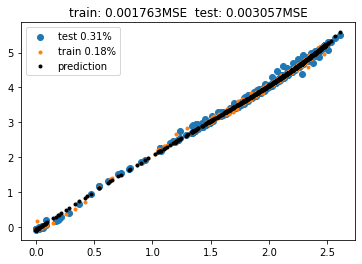

/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.259e-01, tolerance: 5.961e-02
  model = cd_fast.enet_coordinate_descent(


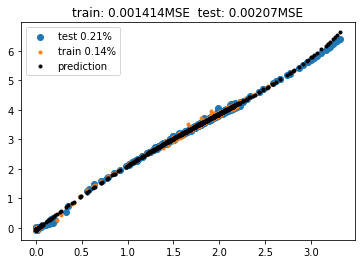

/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.433e-01, tolerance: 9.162e-02
  model = cd_fast.enet_coordinate_descent(


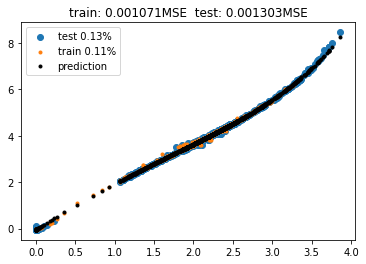

/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.843e+00, tolerance: 1.288e-01
  model = cd_fast.enet_coordinate_descent(


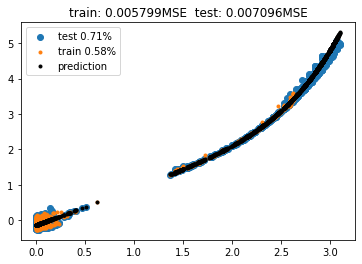

/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.473e-02, tolerance: 2.776e-02
  model = cd_fast.enet_coordinate_descent(


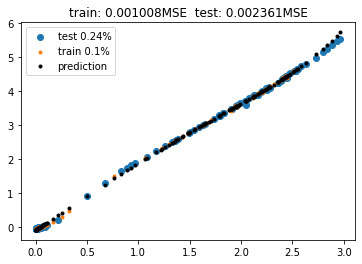

/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.161e-01, tolerance: 3.043e-02
  model = cd_fast.enet_coordinate_descent(


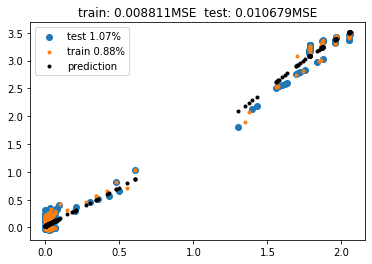

/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.459e-01, tolerance: 7.508e-02
  model = cd_fast.enet_coordinate_descent(


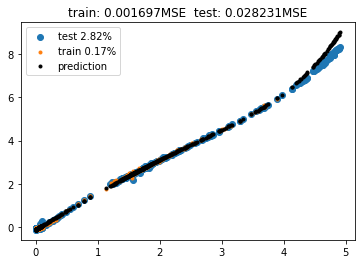

/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.360e-02, tolerance: 3.738e-02
  model = cd_fast.enet_coordinate_descent(


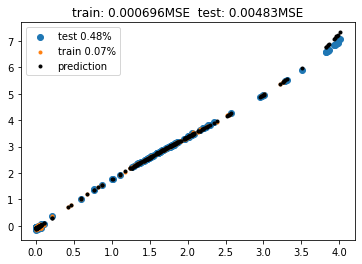

/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.530e-01, tolerance: 7.435e-02
  model = cd_fast.enet_coordinate_descent(


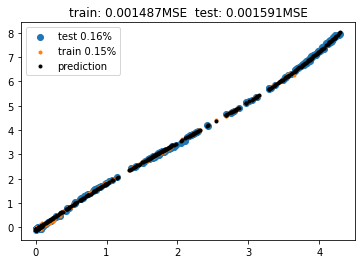

/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.462e-01, tolerance: 4.422e-02
  model = cd_fast.enet_coordinate_descent(


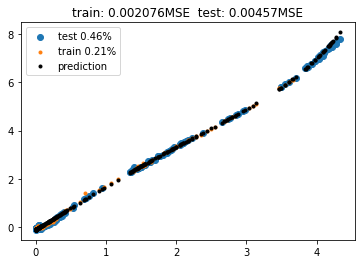

/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.719e-01, tolerance: 6.261e-02
  model = cd_fast.enet_coordinate_descent(


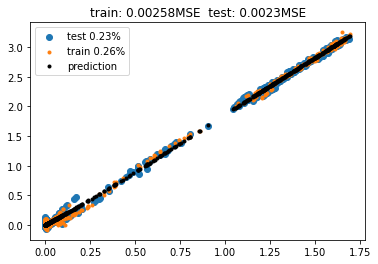

/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.587e-01, tolerance: 3.524e-02
  model = cd_fast.enet_coordinate_descent(


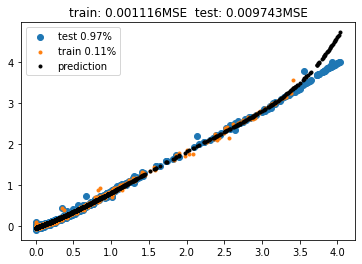

/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.714e-01, tolerance: 3.030e-02
  model = cd_fast.enet_coordinate_descent(


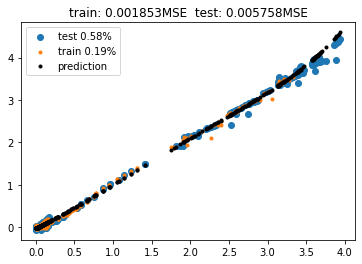

/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.006e-02, tolerance: 5.504e-03
  model = cd_fast.enet_coordinate_descent(


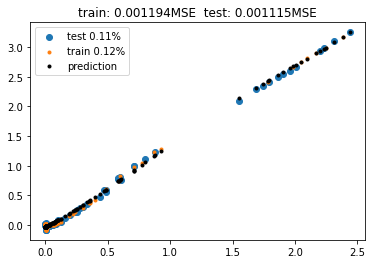

/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.418e-01, tolerance: 3.544e-02
  model = cd_fast.enet_coordinate_descent(


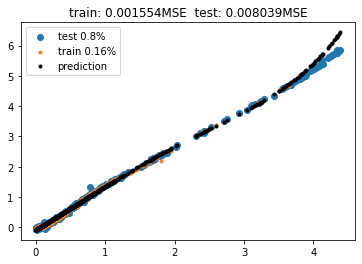

/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.948e-01, tolerance: 7.859e-02
  model = cd_fast.enet_coordinate_descent(


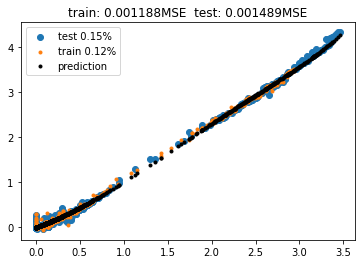

/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.199e-01, tolerance: 4.386e-02
  model = cd_fast.enet_coordinate_descent(


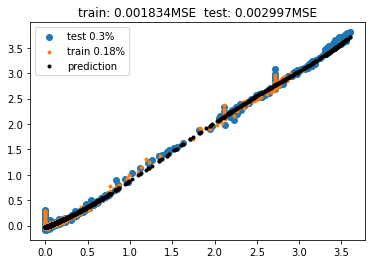

/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.514e-02, tolerance: 3.192e-03
  model = cd_fast.enet_coordinate_descent(


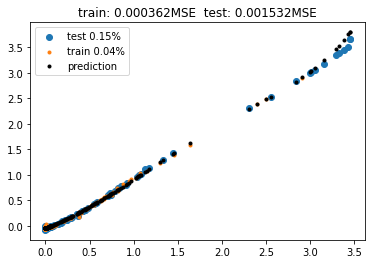

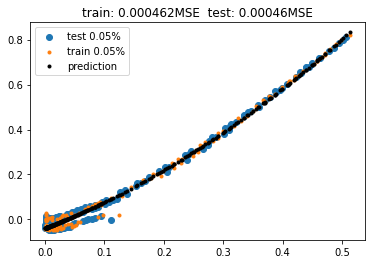

/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.263e-02, tolerance: 4.755e-03
  model = cd_fast.enet_coordinate_descent(


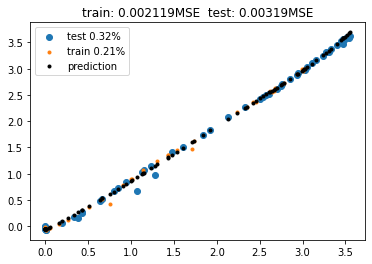

/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.675e-01, tolerance: 2.908e-02
  model = cd_fast.enet_coordinate_descent(


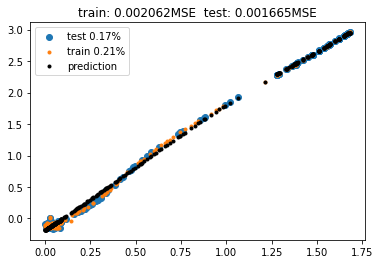

/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.484e-02, tolerance: 3.785e-02
  model = cd_fast.enet_coordinate_descent(


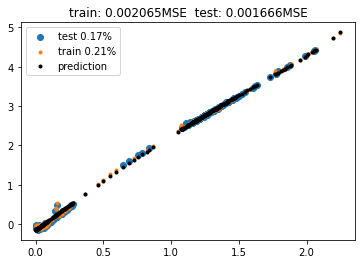

/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.809e-01, tolerance: 2.987e-02
  model = cd_fast.enet_coordinate_descent(


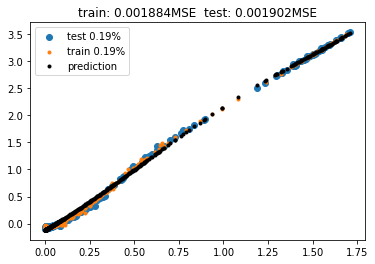

/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.297e-02, tolerance: 1.266e-02
  model = cd_fast.enet_coordinate_descent(


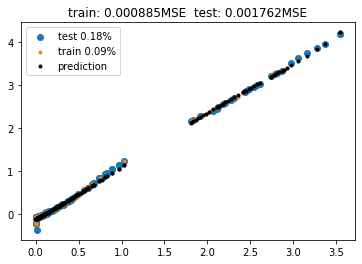

/home/derwer/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.631e-01, tolerance: 3.071e-02
  model = cd_fast.enet_coordinate_descent(


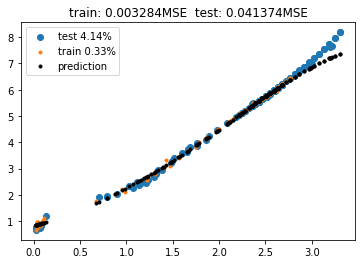

In [22]:
hw = hyperparameter_wrapper(Lasso,degree=6)
la_train, la_test = hw.plot_loop( lasso_alpha, X_trains, X_tests, y_trains, y_tests, substance_ids)

results[ "lasso6" ] = { "error_train":la_train, "error_test":la_test, "alpha":lasso_alpha, "deg":6 }

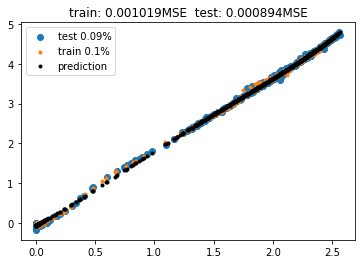

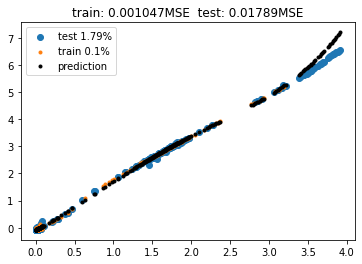

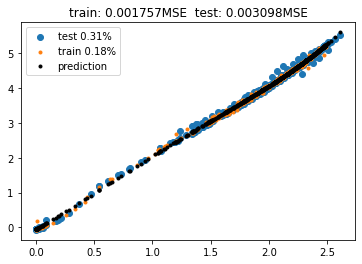

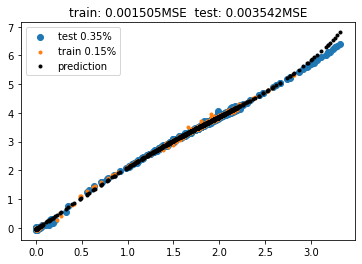

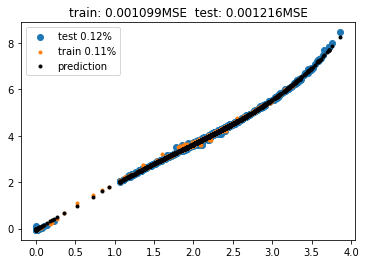

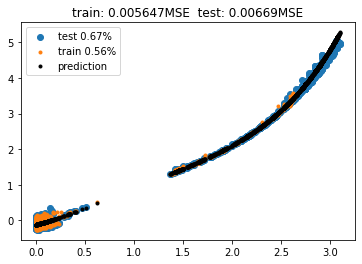

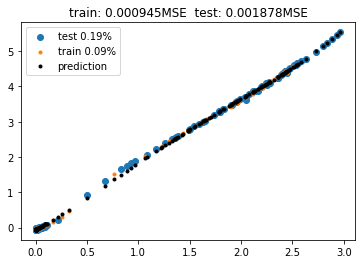

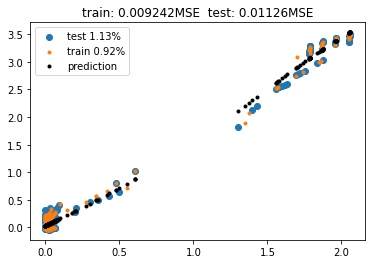

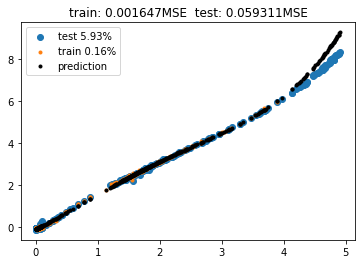

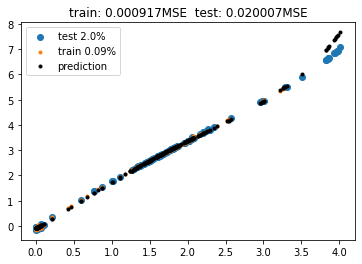

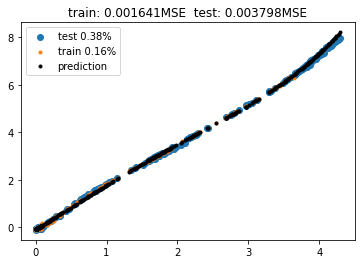

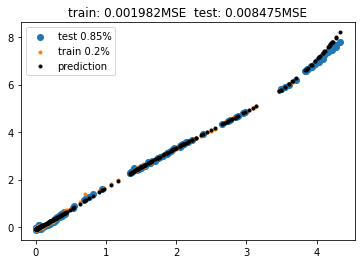

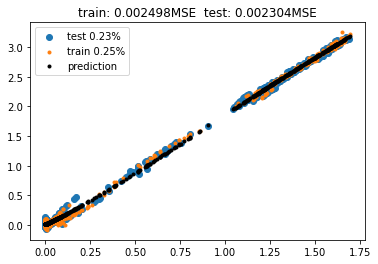

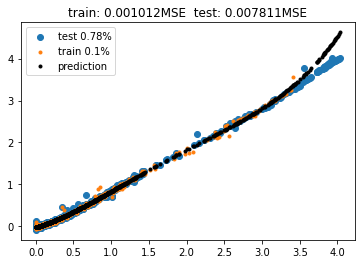

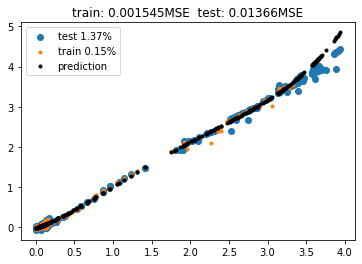

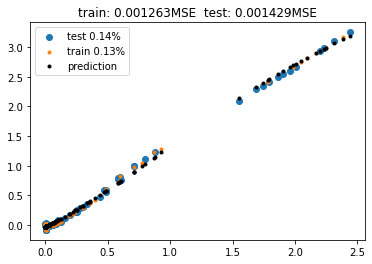

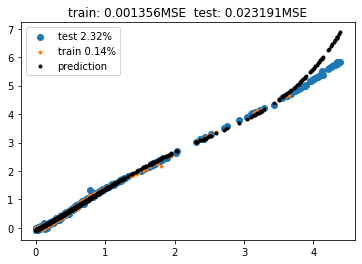

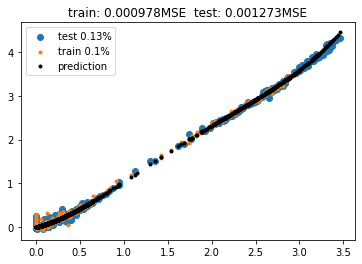

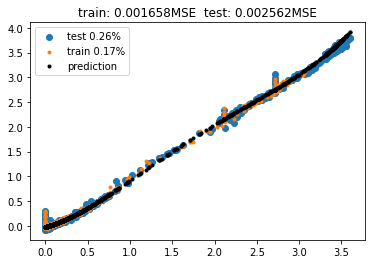

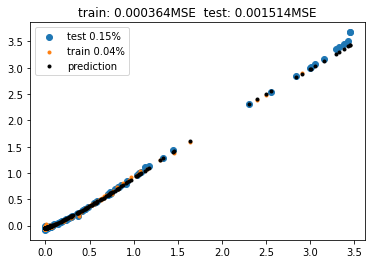

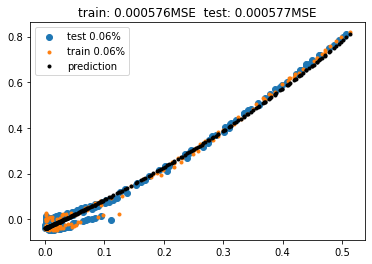

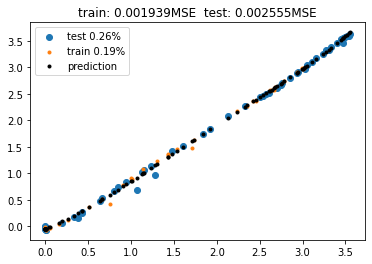

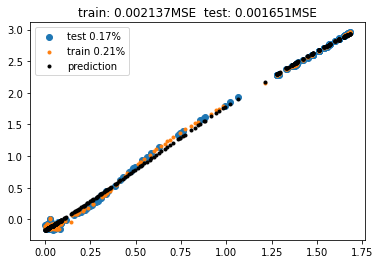

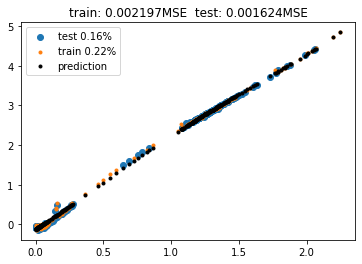

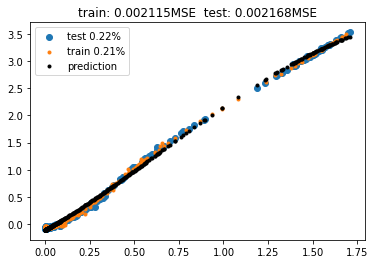

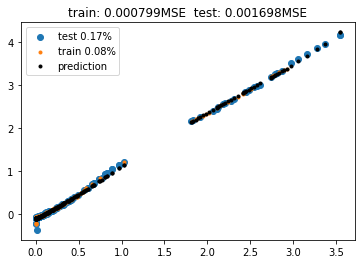

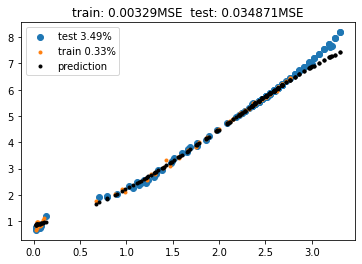

In [23]:
hw = hyperparameter_wrapper(Ridge,degree=ridge_degree)
ri_train, ri_test = hw.plot_loop( ridge_alpha, X_trains, X_tests, y_trains, y_tests, substance_ids)

results[ "ridge" ] = { "error_train":ri_train, "error_test":ri_test, "alpha":ridge_alpha, "deg":ridge_degree }


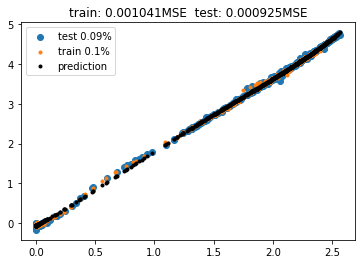

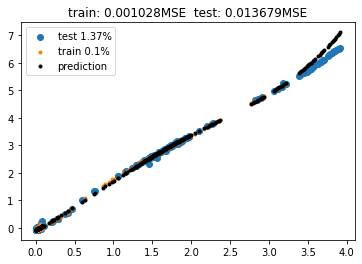

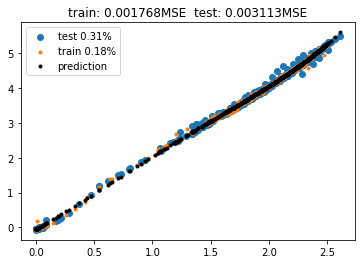

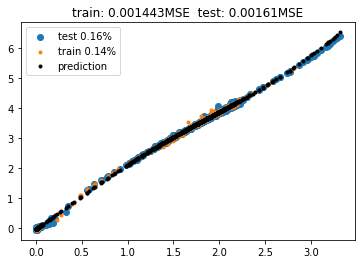

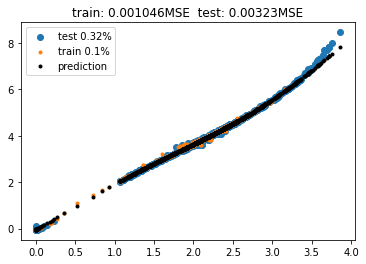

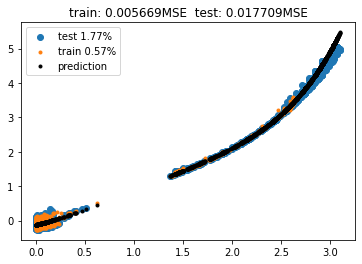

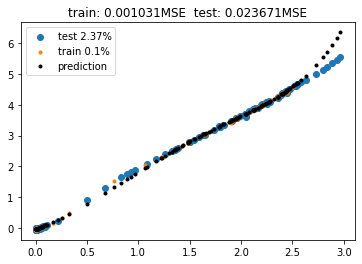

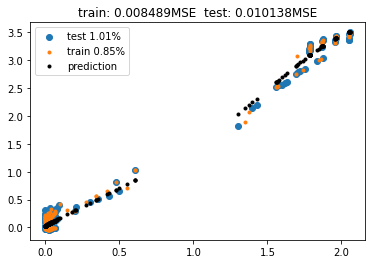

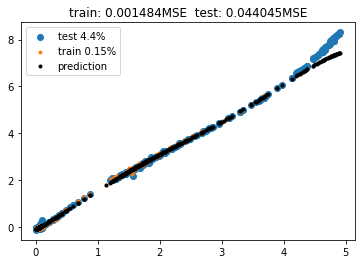

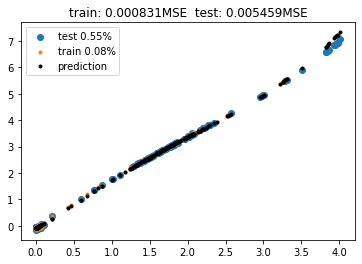

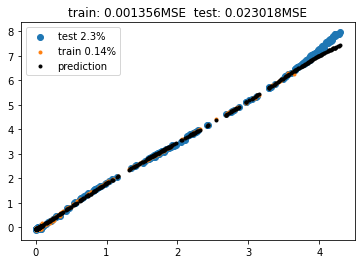

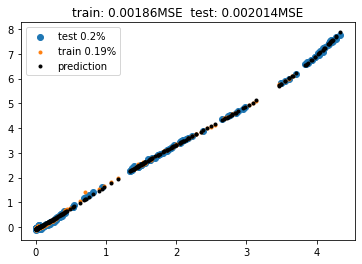

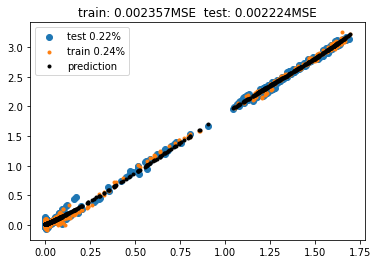

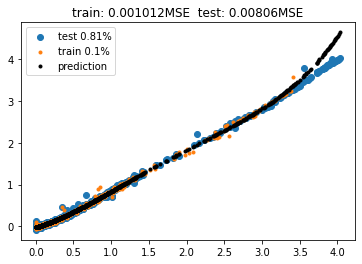

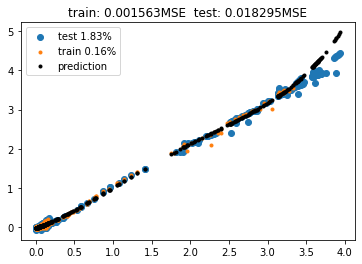

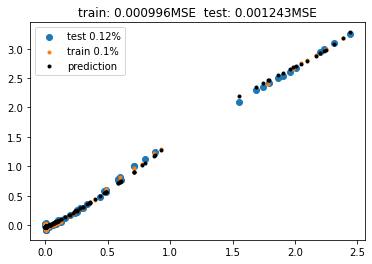

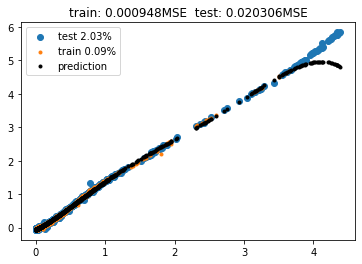

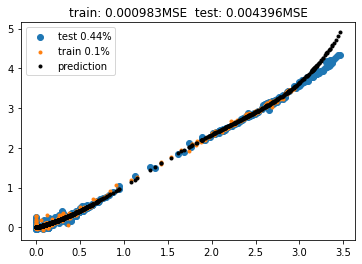

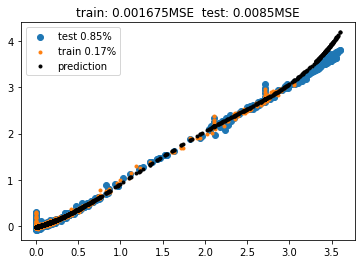

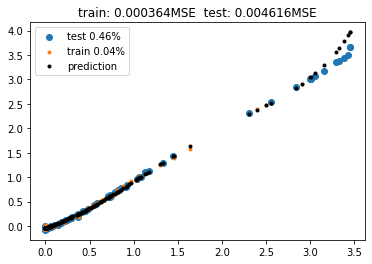

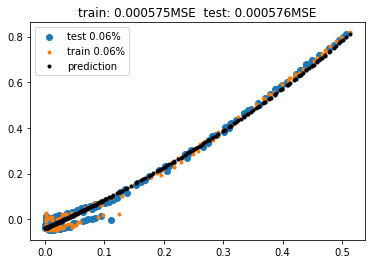

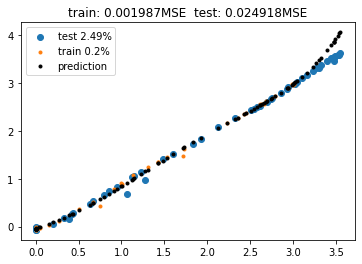

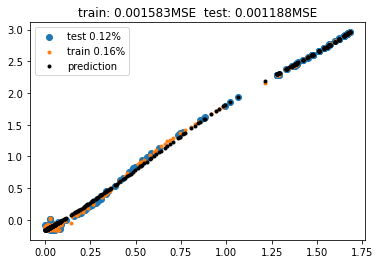

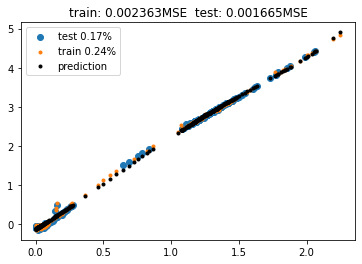

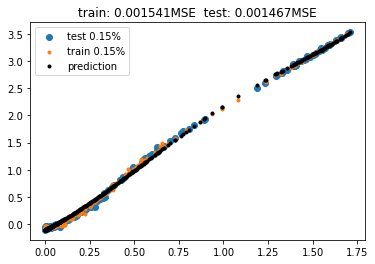

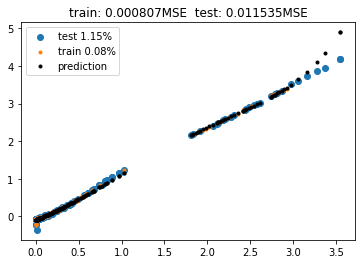

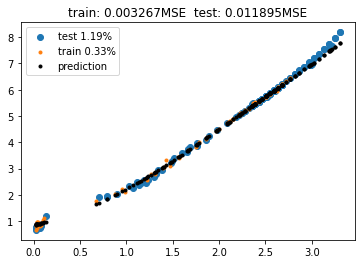

In [24]:
hw = hyperparameter_wrapper(Ridge,degree=5)
ri_train, ri_test = hw.plot_loop( ridge_alpha, X_trains, X_tests, y_trains, y_tests, substance_ids)

results[ "ridge5" ] = { "error_train":ri_train, "error_test":ri_test, "alpha":ridge_alpha, "deg":5 }


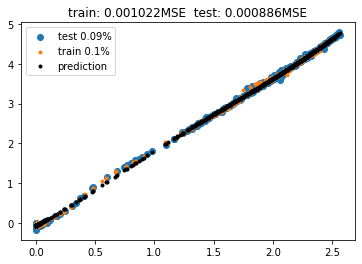

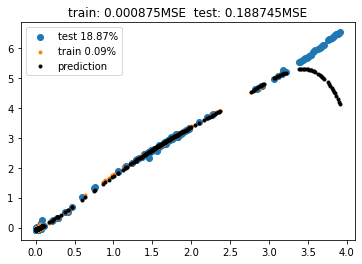

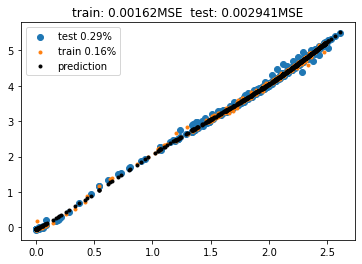

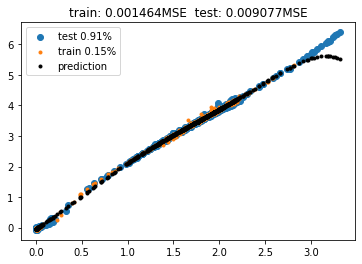

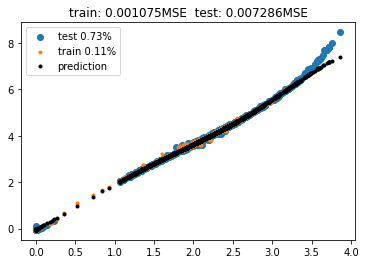

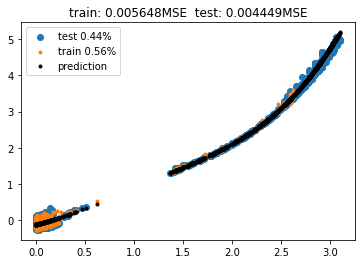

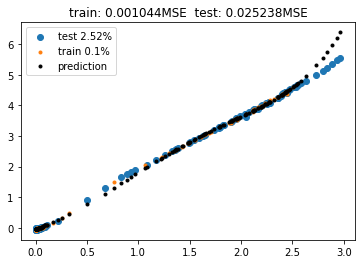

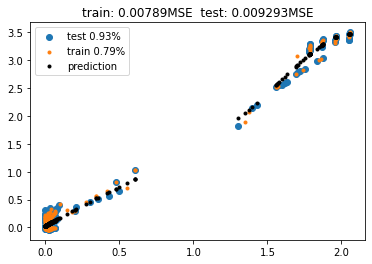

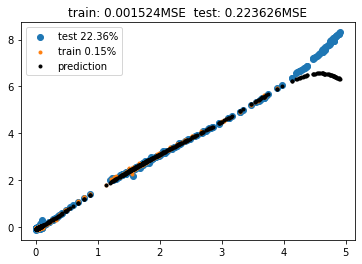

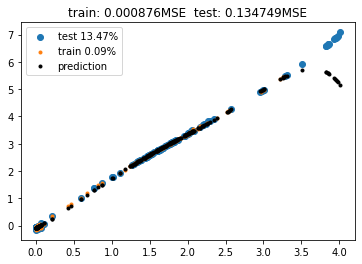

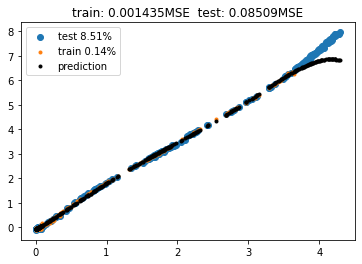

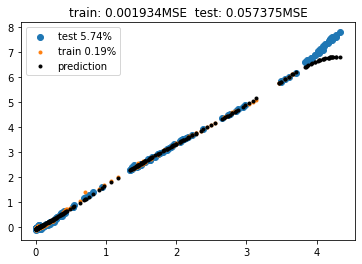

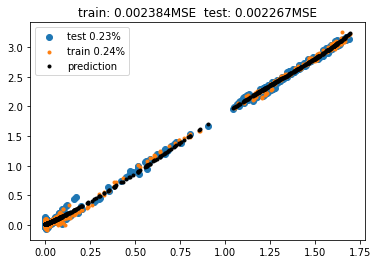

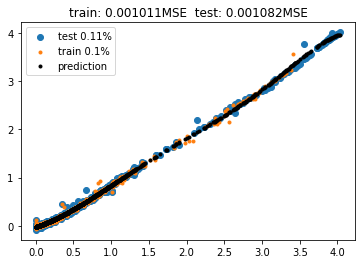

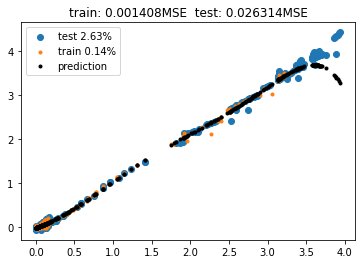

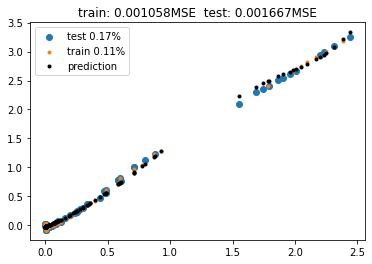

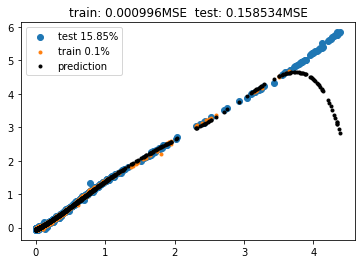

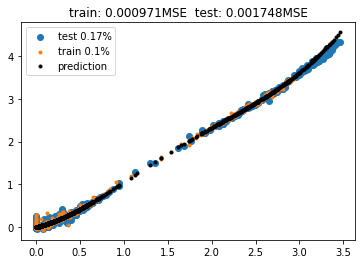

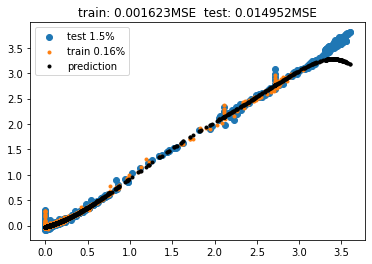

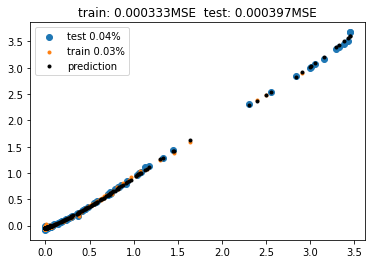

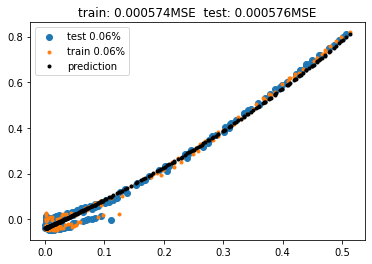

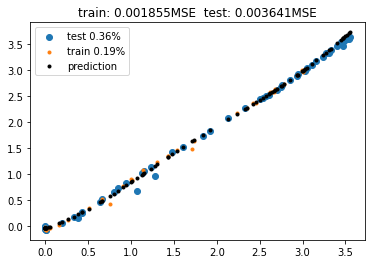

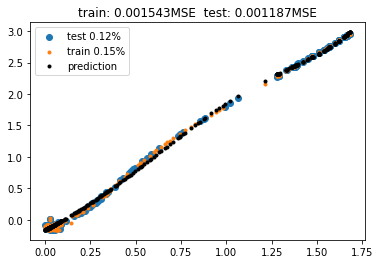

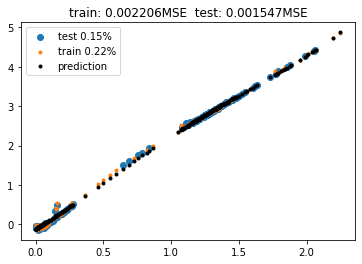

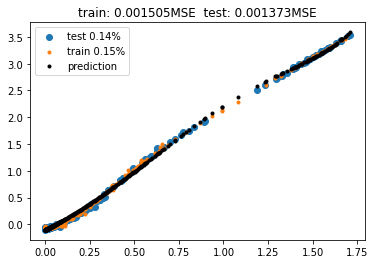

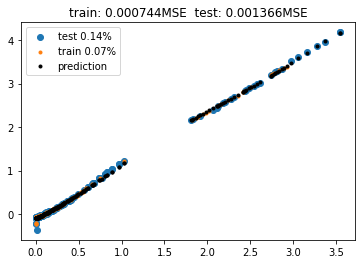

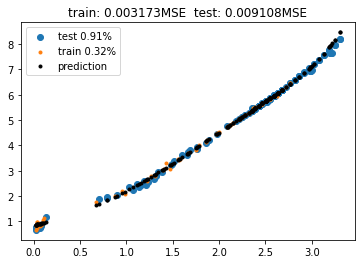

In [25]:
hw = hyperparameter_wrapper(Ridge,degree=6)
ri_train, ri_test = hw.plot_loop( ridge_alpha, X_trains, X_tests, y_trains, y_tests, substance_ids)

results[ "ridge6" ] = { "error_train":ri_train, "error_test":ri_test, "alpha":ridge_alpha, "deg":6 }

# 5. Insights and key findings


As expected, high order polynomials without lasso or ridge fit the training data best. However, the validation data shows that this is overfitting.

In [26]:
df_results = pd.DataFrame(results)
df_results

line     poly3     poly4     poly5     lasso    lasso4  \
error_train  0.003591  0.001827  0.001355  0.001031  0.001545  0.001615   
error_test   0.004952  0.004238  0.003026  0.003398  0.002686  0.002419   
alpha        0.000000  0.000000  0.000000  0.000000  0.000100  0.000100   
deg          1.000000  3.000000  4.000000  5.000000  5.000000  4.000000   

               lasso6     ridge    ridge5    ridge6  
error_train  0.001554  0.001545  0.001443  0.001435  
error_test   0.002361  0.002562  0.005459  0.004449  
alpha        0.000100  0.100000  0.100000  0.100000  
deg          6.000000  4.000000  5.000000  6.000000

Based on the results table shown above we can state that lasso. performed best. The complete removal of parameters when they are not necessary is known in relation to the problem and occurs in form of decision tree-like strategies. Therefore this outcome was somehow expected.
The robustness of Lasso and the underlying strategy is also supported by the fact that Lasso works well independently of the degree of polynomials if the order is only high enough. This can be seen in the pareto knee plot as theres no minimum or optimum degree or alpha (in comparison to ridge) but also in the results table. Here the predictive capabilities degenerate much slower than for linear regression and ridge when higher degrees are chosen.



# 6. Next Steps


- The data set is relatively small. Consequently, the approach could be tested for other substances.
- You could also look at mixtures.
- Or you could try to use correlations between the substances for better predictions based on chemical information and similarities between the substances. This would be a much higher dimensional problem and would require more advanced machine learning methods



## <h3 align="center"> © IBM Corporation 2020. All rights reserved. <h3/>
